## Airline Passenger Reviews Sentiment & Amenity Analysis
### Data Analytics Report
##### Shane McBryde
---

## Purpose Of The Analysis

---
### Research Question
&emsp;&emsp;How does passenger sentiment vary across seating classes (Economy, Premium, Business, and First), passenger types (Solo, Couple, Family, and Professional), and various amenities (Food, Comfort, Entertainment, Ground, and Staff) among the top 10 airlines in 2024?

---
### Data Analysis Goal
&emsp;&emsp;This research seeks to identify how passenger sentiment varies across seating classes, passenger types, and amenity ratings. The goal is to determine whether the value proposition of premium seating aligns with actual passenger experiences and how this relationship is influenced by the traveler's context and specific service amenities. The study will highlight key discrepancies and strengths across different segments, providing insights that airlines can use to improve service delivery and increase customer satisfaction.

---
* [Data Exploration](#Data-Exploration)
  * [Dataset Overview](#Dataset-Overview)
  * [Data Summary](#Data-Summary)
  * [Duplicate Handling](#Duplicate-Handling)
  * [Feature Value Frequency](#Feature-Value-Frequency)
* [Preprocessing](#Preprocessing)
  * [Normalization](#Normalization)
  * [Negation Handling](#Negation-Handling)
  * [Stop Words Removal](#Stop-Words-Removal)
  * [Corpus and Vocabulary](#Corpus-and-Vocabulary)
  * [Vocabulary Pruning](#Vocabulary-Pruning)
  * [Vectorization](#Vectorization)
  * [Data Split](#Data-Split)
  * [Sequence Processing](#Sequence-Processing)
  * [Data Storage](#Data-Storage)
* [Neural Network Model](#Neural-Network-Model)
  * [Hyperparameter Tuning](#Hyperparameter-Tuning)
  * [Model Training](#Model-Training)
* [Performance Assessment](#Performance-Assessment)
  * [Classification Report](#Classification-Report)
  * [ROC Curve and AUC Score](#ROC-Curve-and-AUC-Score)
  * [Confusion Matrix](#Confusion-Matrix)
  * [Model Evaluation](#Model-Evaluation)
* [Prediction Analysis](#Prediction-Analysis)
  * [Misclassification](#Misclassification)
  * [Normality Assessment](#Normality-Assessment)
  * [Statistical Significance](#Statistical-Significance)
  * [Descriptive Statistics](#Descriptive-Statistics)
  * [Distribution Analysis](#Distribution-Analysis)
* [Combined Analysis](#Combined-Analysis)
  * [Summary of Combined Analysis](#Summary-of-Combined-Analysis)
* [Amenities Analysis](#Amenities-Analysis)
  * [Summary of Amenity Analysis](#Summary-of-Amenity-Analysis)

---
---
## Data Exploration

In [7]:
import os
import re
import time
import spacy
import string
import warnings
import numpy as np
import unicodedata
import contractions 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.multicomp as mc

from scikit_posthocs import posthoc_dunn
from collections import Counter, defaultdict
from IPython.display import display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.spatial import distance
from scipy.stats import shapiro, kruskal

from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring, EarlyStopping

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.util import mark_negation

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

seed = 42
np.random.seed(seed) 
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

---
### Dataset Overview
* **Load and Prepare Data:** Import the dataset for analysis.
* **Data Structure and Preview:** Display dataset dimensions and a sample view for initial inspection.

In [9]:
# Import the data, shuffle, and reindex 
# Data scraped from airlinequality.com (A-Z Airline Reviews - SKYTRAX, 2025)

df_reviews = pd.read_csv("airlines_reviews.csv")
df = df_reviews.copy()
# df = df_reviews.iloc[:2500].copy()

# Extract 'Month' and 'Year' into separate columns and drop 'Date Flown' column
df[['Month', 'Year']] = df['Date Flown'].str.extract(r'([A-Za-z]+)\s+(\d{4})')
df = df.drop(['Date Flown'], axis='columns')

# Rename columns
df.rename(columns={'Type of Traveller': 'Type', 
                   'Seat Comfort': 'Comfort', 
                   'Staff Service': 'Staff', 
                   'Ground Service': 'Ground',
                   'Food & Beverages': 'Food', 
                   'Inflight Entertainment': 'Entertainment', 
                   'Value For Money': 'Value',
                   'Overall Rating': 'Rating'}, inplace=True)

# Rename Class and Traveller Type values
class_mapping = {
    'Economy Class': 'Economy',
    'Premium Economy': 'Premium',
    'Business Class': 'Business',
    'First Class': 'First'}
df['Class'] = df['Class'].map(class_mapping)

type_mapping = {
    'Solo Leisure': 'Solo',
    'Couple Leisure': 'Couple',
    'Family Leisure': 'Family',
    'Business': 'Business'}
df['Type'] = df['Type'].map(type_mapping)

# Change column order
df = df[['Airline', 'Reviews', 'Type', 'Class', 'Month', 'Year', 'Comfort', 
         'Staff', 'Ground', 'Food', 'Entertainment', 'Value', 'Rating', 'Recommended']]

# Retain records that conform to the following: Year = 2015-2024
df = df[(df['Year'] >= '2015') & (df['Year'] <= '2024')]

# Convert True/False values to integer values
df['Recommended'] = df['Recommended'].astype(int)

# Randomly shuffle the dataframe rows
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# Show size and display sample view
display(Markdown("##### Size And Sample View<br>"))
print(f"{'Rows':<11}{df.shape[0]:>5}\n{'Columns':<11}{df.shape[1]:>5}\n")
display(df.head())
display(Markdown("**<br>Shuffling reduces potential bias during training.**"))

##### Size And Sample View<br>

Rows       11079
Columns       14



,Airline,Reviews,Type,Class,Month,Year,Comfort,Staff,Ground,Food,Entertainment,Value,Rating,Recommended
0,Turkish Airlines,✅ Trip Verified | After flying with TA my lugg...,Business,Economy,July,2023,1.0,3.0,1.0,5.0,5.0,1.0,2.0,0
1,Cathay Pacific Airways,✅ Verified Review | On 20th December 2016 my ...,Couple,First,January,2017,4.0,5.0,5.0,5.0,5.0,1.0,1.0,0
2,Air France,✅ Trip Verified | My flight on 1st March was ...,Solo,Economy,March,2024,4.0,1.0,3.0,4.0,2.0,3.0,2.0,0
3,Turkish Airlines,✅ Trip Verified | I was supposed to fly from ...,Business,Economy,February,2019,3.0,4.0,1.0,5.0,5.0,1.0,1.0,0
4,Qatar Airways,✅ Trip Verified | Bombay to Dallas via Doha. ...,Couple,Economy,July,2018,5.0,3.0,5.0,1.0,4.0,4.0,6.0,1


**<br>Shuffling reduces potential bias during training.**

---
### Data Summary
* **Feature Overview:** Examine data types for each feature.
* **Missing Data Check:** Identify and assess null values in the dataset.

In [11]:
# Review data types and identify features containing null values.
display(Markdown("##### Data Summary<br>"))
print(f"{df.info()}")

display(Markdown("##### <br>Null Counts<br>"))
for col in df.columns:
    print(f"{col:<25}{df[col].isnull().sum()}")

# Drop rows with null values
before_drop = df.shape[0]
df.dropna(inplace=True)

display(Markdown("##### <br>Null Rows Dropped<br>"))
print(f"{'Dropped':<11}{before_drop - df.shape[0]:>5}\n")
print(f"{'Rows':<11}{df.shape[0]:>5}\n{'Columns':<11}{df.shape[1]:>5}")
    
display(Markdown("**<br>Handling nulls is important in order to avoiding errors during training.**"))

##### Data Summary<br>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11079 entries, 0 to 11078
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Airline        11079 non-null  object 
 1   Reviews        11079 non-null  object 
 2   Type           11079 non-null  object 
 3   Class          11079 non-null  object 
 4   Month          11079 non-null  object 
 5   Year           11079 non-null  object 
 6   Comfort        11079 non-null  float64
 7   Staff          11079 non-null  float64
 8   Ground         10813 non-null  float64
 9   Food           11079 non-null  float64
 10  Entertainment  11039 non-null  float64
 11  Value          11079 non-null  float64
 12  Rating         11079 non-null  float64
 13  Recommended    11079 non-null  int64  
dtypes: float64(7), int64(1), object(6)
memory usage: 1.2+ MB
None


##### <br>Null Counts<br>

Airline                  0
Reviews                  0
Type                     0
Class                    0
Month                    0
Year                     0
Comfort                  0
Staff                    0
Ground                   266
Food                     0
Entertainment            40
Value                    0
Rating                   0
Recommended              0


##### <br>Null Rows Dropped<br>

Dropped      266

Rows       10813
Columns       14


**<br>Handling nulls is important in order to avoiding errors during training.**

---
### Duplicate Handling
* **Duplicate Detection:** Identify duplicate entries in the dataset.
* **Duplicate Removal:** Eliminate redundant records to ensure data integrity.

In [13]:
# Remove verification text from Reviews
display(Markdown("##### Duplicate Reviews<br>"))
df['Reviews'] = df['Reviews'].apply(lambda x: x.split('|', maxsplit=1)[1] if 'Verified |' in x else x)
df['Reviews'] = df['Reviews'].apply(lambda x: x.split('|', maxsplit=1)[1] if 'Unverified |' in x else x)
df['Reviews'] = df['Reviews'].apply(lambda x: x.split('|', maxsplit=1)[1] if 'Review |' in x else x)

# Replace multiple spaces with a single space and strip leading/trailing white space
df = df.map(lambda x: re.sub(r'\s+', ' ', x.strip()) if isinstance(x, str) else x)

# Delete duplicates from Reviews
duplicate = df['Reviews'].duplicated()
print(f"{'Count':<9}{duplicate.sum()}", end='\n\n')
display(df[duplicate])
df = df.drop(df[duplicate].index)

display(Markdown("##### <br>Size After Duplicate Deletions<br>"))
print(f"{'Rows':<11}{df.shape[0]:>5}\n{'Columns':<11}{df.shape[1]:>5}")
display(Markdown("**<br>Duplicate records can bias the model and skew performance metrics.**"))

##### Duplicate Reviews<br>

Count    2



,Airline,Reviews,Type,Class,Month,Year,Comfort,Staff,Ground,Food,Entertainment,Value,Rating,Recommended
7704,Emirates,Unforgettable experience flying with Emirates ...,Solo,Economy,November,2017,2.0,5.0,5.0,2.0,5.0,2.0,2.0,0
9091,EVA Air,Another great set of flights R/T Bangkok to Sa...,Business,Business,July,2023,5.0,5.0,5.0,1.0,5.0,5.0,10.0,1


##### <br>Size After Duplicate Deletions<br>

Rows       10811
Columns       14


**<br>Duplicate records can bias the model and skew performance metrics.**

---
### Feature Value Frequency  
* **Column Value Frequency:** Calculate the value counts for each column to assess distribution patterns.
* **Grouped Value Frquency:** Calculate the value counts for each combination of the Class and Type features.

In [15]:
# Display value counts
display(Markdown("##### Value Counts<br>"))
for col in df.columns:
    if col != 'Reviews':
        print(df[col].value_counts().sort_index(), end='\n\n')
display(Markdown("**<br>Value counts provides a good overview of the data distribution for each feature in \
the data set.**"))

##### Value Counts<br>

Airline
Air France                       1025
All Nippon Airways                340
Cathay Pacific Airways            995
EVA Air                           351
Emirates                         1770
Japan Airlines                    166
Qatar Airways                    2092
Singapore Airlines               1181
Swiss International Air Lines     757
Turkish Airlines                 2134
Name: count, dtype: int64

Type
Business    1878
Couple      2604
Family      2052
Solo        4277
Name: count, dtype: int64

Class
Business    2850
Economy     7282
First        199
Premium      480
Name: count, dtype: int64

Month
April         803
August       1020
December     1019
February      807
January       950
July          939
June          729
March         852
May           792
November      935
October       997
September     968
Name: count, dtype: int64

Year
2015     996
2016    1548
2017    1439
2018    1422
2019    1520
2020     560
2021     475
2022     967
2023    1044
2024     840


**<br>Value counts provides a good overview of the data distribution for each feature in the data set.**

## <br>Preprocessing

---
### Normalization  
* **Lowercase Conversion:** Convert all text to lowercase for consistency.  
* **Contraction Expansion:** Expand contractions (e.g., "can't" → "cannot") to standardize wording.  
* **Accent Removal:** Eliminate accented characters to ensure uniform text processing.  
* **Number Removal:** Strip numerical values unless they provide essential meaning to the text.

In [18]:
# Normalize text
display(Markdown("##### Normalized Data<br>"))

def normalize_text(text):
    # Convert to lowcase and remove URLs
    text = text.lower()
    text = re.sub(r'<[^>]+>|https?://\S+', '', text)

    # Fix non-ASCII apostrophes before contraction expansion
    text = re.sub(r'[‘’´`]', "'", text)
    text = contractions.fix(text)

    # Normalize Unicode characters and remove accents (GeeksforGeeks, 2024)
    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])

    # Filter valid characters
    normalized_chars = []
    for char in text:
        if unicodedata.category(char).startswith('L') \
        or char.isspace() \
        or char in {'.', '!', '?', ';', ':', '--', ','}:
            normalized_chars.append(char)

    # Normalize white space and remove or combine phrases
    text = re.sub(r'\s+', ' ', ''.join(normalized_chars)).strip()
    text = re.sub(r'\bnot only\b', '', text)
    text = re.sub(r'\bor not\b', '', text)
    text = re.sub(r'\bon time\b', 'on_time', text)
    text = re.sub(r'\bon schedule\b', 'on_time', text)
    return text

df['Normalized'] = df['Reviews'].apply(normalize_text)

display(df['Normalized'].head())
display(Markdown("**<br>Text normalization standardizes the input text by converting it to lowercase, \
expanding contractions, and fixing non-ASCII apostrophes for consistency. It further processes the \
text by stripping HTML tags and URLs, normalizing Unicode characters (removing accents), and filtering \
out non-letter symbols while preserving multilingual content. These steps ensure linguistic uniformity, \
minimize noise, and create a cleaner dataset for NLP tasks.**"))

##### Normalized Data<br>

0    after flying with ta my luggage has been delay...
1    on th december my wife and i were booked to fl...
2    my flight on st march was delayed for more tha...
3    i was supposed to fly from dubai to atltanta v...
4    bombay to dallas via doha. i traveled with qat...
Name: Normalized, dtype: object

**<br>Text normalization standardizes the input text by converting it to lowercase, expanding contractions, and fixing non-ASCII apostrophes for consistency. It further processes the text by stripping HTML tags and URLs, normalizing Unicode characters (removing accents), and filtering out non-letter symbols while preserving multilingual content. These steps ensure linguistic uniformity, minimize noise, and create a cleaner dataset for NLP tasks.**

---
### Negation Handling  
* **Negation Identification:** Detect phrases where negation alters meaning.  
* **Negation Tagging:** Mark text as negated where necessary to maintain sentiment accuracy.

In [20]:
# Mark words that are negated 
display(Markdown("##### Negation Handling<br>"))

# Enable GPU processing and load spaCy model
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_lg", disable=["ner", "textcat"])

# Stop words
STOP_WORDS = nlp.Defaults.stop_words
AIRLINE_STOP_WORDS = STOP_WORDS - {"not", "no", "never", "neither", "nor"}

def negation_handling(text, window_size=3):
    doc = nlp(text)
    negated_tokens = []
    i = 0
    n = len(doc)
    negation_active = False

    while i < n:
        token = doc[i]
        
        # Case 1: "no + noun" pattern
        if token.text.lower() == 'no' and i + 1 < n and doc[i + 1].pos_ == 'NOUN':
            negated_tokens.extend([token.text, f"{doc[i + 1].text}_NEG"])
            i += 2
            continue
            
        # Case 2: Handle "was not"/"is not" with extended window
        if (token.text.lower() in {"was", "is"} and i + 1 < n 
            and doc[i + 1].text.lower() == "not"):
            negated_tokens.extend([token.text, "not"])
            j = i + 2
            words_negated = 0
            
            while j < n and words_negated < window_size + 1:  # Slightly extended window
                next_token = doc[j]
                
                if next_token.text in {'.', '!', '?', ';', ':'}:
                    negated_tokens.append(next_token.text)
                    j += 1
                    break
                    
                if next_token.pos_ in ('ADJ', 'VERB', 'ADV', 'NOUN') and \
                   next_token.text.lower() not in AIRLINE_STOP_WORDS:
                    negated_tokens.append(f"{next_token.text}_NEG")
                    words_negated += 1
                else:
                    negated_tokens.append(next_token.text)
                
                j += 1
            
            i = j
            continue
            
        # Case 3: Standard negation words
        if token.text.lower() in {"not", "no", "never", "neither", "nor"}:
            negation_active = True
            negated_tokens.append(token.text)
            j = i + 1
            words_negated = 0
            
            # Special case: "not the/this/that + noun"
            if (j + 1 < n and doc[j].text.lower() in {'the', 'this', 'that'} 
                and doc[j + 1].pos_ in ('NOUN', 'PROPN')):
                negated_tokens.append(doc[j].text)
                negated_tokens.append(f"{doc[j + 1].text}_NEG")
                i = j + 2
                continue
                
            while j < n and words_negated < window_size:
                next_token = doc[j]
                
                if next_token.text in {'.', '!', '?', ';', ':', '--', ','} or \
                   next_token.text.lower() in {'which', 'that', 'who', 'and', 'but'}:
                    negation_active = False
                    negated_tokens.append(next_token.text)
                    j += 1
                    break
                
                if next_token.pos_ == 'ADV' and j + 1 < n and doc[j + 1].pos_ == 'ADJ':
                    negated_tokens.append(f"{next_token.text}_NEG")
                    negated_tokens.append(f"{doc[j + 1].text}_NEG")
                    j += 2
                    words_negated += 2
                    continue
                
                if (negation_active and 
                    next_token.pos_ in ('ADJ', 'VERB', 'ADV', 'NOUN') and
                    next_token.text.lower() not in AIRLINE_STOP_WORDS):
                    negated_tokens.append(f"{next_token.text}_NEG")
                    words_negated += 1
                else:
                    negated_tokens.append(next_token.text)
                    if next_token.text.lower() not in {"or", "nor"}:
                        negation_active = False
                
                if next_token.text.lower() in {"or", "nor"}:
                    negation_active = True

                j += 1
            
            i = j
            continue
        
        # Default case
        negated_tokens.append(token.text)
        i += 1

    return " ".join(negated_tokens)

df['Negated'] = df['Normalized'].apply(negation_handling)

display(df['Negated'].head())
display(Markdown("**<br>Marking negations improves the ability of the model to detect context changes due \
to negation words.**"))

##### Negation Handling<br>

0    after flying with ta my luggage has been delay...
1    on th december my wife and i were booked to fl...
2    my flight on st march was delayed for more tha...
3    i was supposed to fly from dubai to atltanta v...
4    bombay to dallas via doha . i traveled with qa...
Name: Negated, dtype: object

**<br>Marking negations improves the ability of the model to detect context changes due to negation words.**

---
### Stop Words Removal
* **Lemmatization:** Convert words to their base form for consistency.  
* **Stop Word Removal:** Eliminate common words that do not contribute to meaning.

In [22]:
# lemmatization, and removing stop words 
display(Markdown("##### Lemmatized Data Filtered For Stop Words<br>"))
    
def remove_punct(text):
    # Remove punctuation
    text = re.sub(r'[\.\!\?,;:\-]', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    # Remove punctuation
    punct_removed = remove_punct(text)
    
    # lemmatization and stopword removal
    processed_tokens = []
    for token in nlp(punct_removed):
        if "_NEG" in token.text:
            base = token.text.replace("_NEG", "")
            base_doc = nlp(base)
            lemma = base_doc[0].lemma_.lower() + "_NEG" if len(base_doc) == 1 else base.lower() + "_NEG"
        else:
            lemma = token.lemma_.lower()
        
        if lemma.replace("_NEG", "") not in STOP_WORDS:
            processed_tokens.append(lemma)
    
    return " ".join(processed_tokens)

old_word_count = len(set(" ".join(df['Negated']).split()))
df['Preprocessed'] = df['Negated'].apply(preprocess_text)
new_word_count = len(set(" ".join(df['Preprocessed']).split()))

print(f"{'Initial Unique Words':<24}{old_word_count:>4}")
print(f"{'Stop Words Removed':<24}{old_word_count - new_word_count:>4}\n")
print(f"{'Final Unique Words':<24}{new_word_count:>4}\n")

display(df['Preprocessed'].head())
display(Markdown("**<br>Lemmatization reduces vocabulary size and focuses on the core meaning of words, \
improving generalization and reducing redundancy. Stop words removal reduces noise by removing words with \
little semantic value while retaining context of important words including negations.**"))

##### Lemmatized Data Filtered For Stop Words<br>

Initial Unique Words    27263
Stop Words Removed      5570

Final Unique Words      21693



0    fly ta luggage delay week month chat support s...
1    th december wife book fly johannesburg hong ko...
2    flight st march delay hour paris airport coupl...
3    suppose fly dubai atltanta istanbul turkish ai...
4    bombay dallas doha travel qatar time complaint...
Name: Preprocessed, dtype: object

**<br>Lemmatization reduces vocabulary size and focuses on the core meaning of words, improving generalization and reducing redundancy. Stop words removal reduces noise by removing words with little semantic value while retaining context of important words including negations.**

---
### Corpus and Vocabulary  
* **Corpus Statistics:** Compute key metrics, such as total word count and unique word frequency.  
* **Vocabulary Coverage Analysis:** Generate and plot the vocabulary coverage curve to assess word distribution.

##### Corpus And Vocabulary Statistics<br>

Document Count:      10811
Avg Doc Length:      65.06
Total Word Count:   703316
Vocabulary Size:     21693

Top 10 Words:
	flight       22264
	seat         10406
	service       8938
	airline       8449
	good          6792
	time          5847
	food          5846
	hour          5811
	fly           5603
	crew          5195


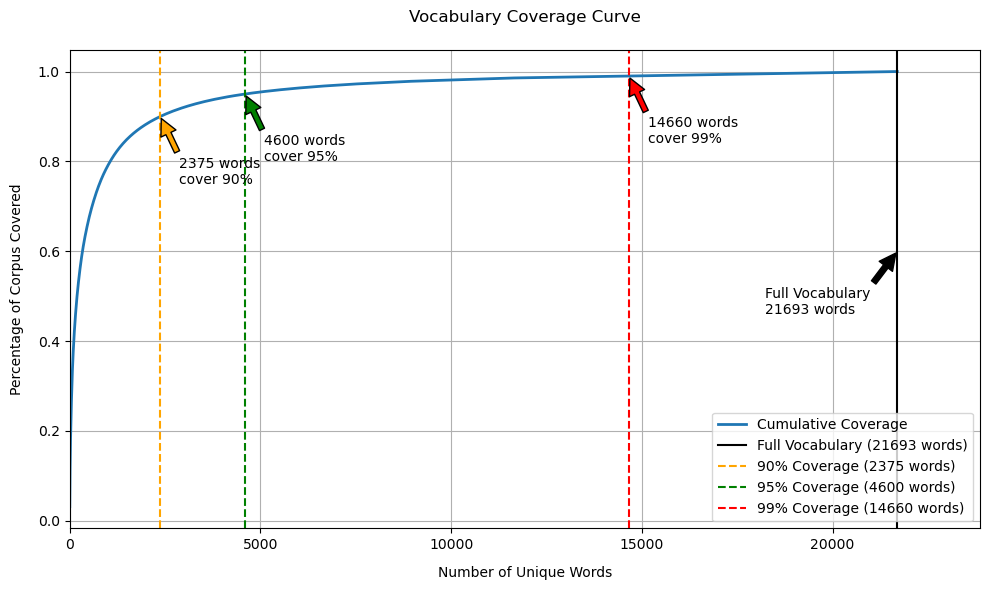


Number of words needed for coverage:
- 90% coverage: 2375 words (10.9% of vocabulary)
- 95% coverage: 4600 words (21.2% of vocabulary)
- 99% coverage: 14660 words (67.6% of vocabulary)


**<br>Determining the vocabulary size is critical for model design. The plot highlights the cumulative vocabulary coverage with the vertical black line marking the vocabulary size for context. As shown, as few as 2375 words out of the 21693 word vocabulary covers 90% of the total word count of 703316 word.**

In [24]:
# Calculate corpus and vocabulary statistics
display(Markdown("##### Corpus And Vocabulary Statistics<br>"))

doc_lengths = df['Preprocessed'].apply(lambda x: len(x.split()))
all_words = ' '.join(df['Preprocessed']).split()
word_counts = Counter(all_words)
sorted_counts = sorted(word_counts.values(), reverse=True)
total_words = sum(sorted_counts)
vocab_size = len(word_counts)

print(f"{'Document Count:':<20}{len(df):>6}")
print(f"{"Avg Doc Length:":<20}{round(doc_lengths.mean(), 2):>6}")
print(f"{'Total Word Count:':<20}{total_words:>6}")
print(f"{'Vocabulary Size:':<20}{vocab_size:>6}\n")

print("Top 10 Words:")
for word, count in Counter(all_words).most_common(10):
    print(f"\t{word:<12}{count:>6}")

# Calculate cumulative coverage
cumulative_coverage = np.cumsum(sorted_counts) / total_words

# Find thresholds
coverage_90 = np.argmax(cumulative_coverage >= 0.90) + 1
coverage_95 = np.argmax(cumulative_coverage >= 0.95) + 1
coverage_99 = np.argmax(cumulative_coverage >= 0.99) + 1

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_coverage) + 1), cumulative_coverage, 
         label='Cumulative Coverage', linewidth=2)

# Add vocabulary size line (SOLID LINE)
plt.axvline(vocab_size, color='black', linestyle='-', linewidth=1.5,
            label=f'Full Vocabulary ({vocab_size} words)')

# Add threshold lines (dashed)
plt.axvline(coverage_90, color='orange', linestyle='--', 
            label=f'90% Coverage ({coverage_90} words)')
plt.axvline(coverage_95, color='green', linestyle='--', 
            label=f'95% Coverage ({coverage_95} words)')
plt.axvline(coverage_99, color='red', linestyle='--', 
            label=f'99% Coverage ({coverage_99} words)')

plt.title('Vocabulary Coverage Curve', pad=20)
plt.xlabel('Number of Unique Words', labelpad=10)
plt.ylabel('Percentage of Corpus Covered', labelpad=10)
plt.legend(loc='lower right')
plt.grid()

# Add annotations
plt.annotate(f'Full Vocabulary\n{vocab_size} words', 
             xy=(vocab_size, 0.6), xytext=(vocab_size*0.84, 0.46),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate(f'{coverage_90} words\ncover 90%', 
             xy=(coverage_90, 0.9), xytext=(coverage_90+500, 0.75),
             arrowprops=dict(facecolor='orange', shrink=0.05))

plt.annotate(f'{coverage_95} words\ncover 95%', 
             xy=(coverage_95, 0.95), xytext=(coverage_95+500, 0.8),
             arrowprops=dict(facecolor='green', shrink=0.05))

plt.annotate(f'{coverage_99} words\ncover 99%', 
             xy=(coverage_99, 0.99), xytext=(coverage_99+500, 0.84),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.xlim(0, vocab_size * 1.1)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nNumber of words needed for coverage:")
print(f"- 90% coverage: {coverage_90} words ({coverage_90/vocab_size:.1%} of vocabulary)")
print(f"- 95% coverage: {coverage_95} words ({coverage_95/vocab_size:.1%} of vocabulary)")
print(f"- 99% coverage: {coverage_99} words ({coverage_99/vocab_size:.1%} of vocabulary)")

display(Markdown(f"**<br>Determining the vocabulary size is critical for model design. The plot \
highlights the cumulative vocabulary coverage with the vertical black line marking the vocabulary size \
for context. As shown, as few as {coverage_90} words out of the {vocab_size} word vocabulary covers \
90% of the total word count of {total_words} word.**"))

---
#### Vocabulary Pruning 
* **Vocabulary Pruning:** Limit word usage to the selected coverage threshold to improve model efficiency.

In [26]:
# Calculate and apply reduced vocabulary size
display(Markdown("##### Reduced Vocabulary Statistics<br>"))

# Calculate word frequencies and sort (descending)
threshold = 0.90
# threshold = 0.99
all_words = ' '.join(df['Preprocessed']).split()
word_counts = Counter(all_words)
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*sorted_words)  # Unzip into separate lists

# Calculate cumulative coverage
cumulative_counts = np.cumsum(counts)
total_words = sum(counts)
coverage_percentages = cumulative_counts / total_words

# Find coverage threshold
coverage_index = np.argmax(coverage_percentages >= threshold) + 1
vocab_reduced = set(words[:coverage_index])
df['Reduced'] = df['Preprocessed'].apply(
    lambda text: ' '.join(word for word in text.split() if word in vocab_reduced))

original_vocab_size = len(word_counts)
reduced_vocab_size = len(vocab_reduced)
coverage = sum(counts[:coverage_index]) / total_words
reduced_total_words = len(' '.join(df['Reduced']).split())
orig_max_seq_length = max(df['Preprocessed'].apply(lambda x: len(x.split())))
max_seq_length = max(df['Reduced'].apply(lambda x: len(x.split())))

# Save the reduced vocabulary for later use
df_vocab_reduced = pd.DataFrame({'word': words[:coverage_index], 'count': counts[:coverage_index]})

print(f"{"Original Vocabulary Size:":<33}{original_vocab_size:>6}")
print(f"{"Reduced Vocabulary Size:":<33}{reduced_vocab_size:>6}")
print(f"{"Actual Coverage Achieved:":<33}{coverage:>6.0%}", end='\n\n')
print(f"{"Original Total Word Count:":<33}{total_words:>6}")
print(f"{"Reduced Total Word Count:":<33}{reduced_total_words:>6}", end='\n\n')
print(f"{"Original Max Sequence Length:":<33}{orig_max_seq_length:>6}")
print(f"{"Reduced Max Sequence Length:":<33}{max_seq_length:>6}")

display(Markdown(f"**<br>This reduction in vocabulary size should save a considerable amount of processing time \
with minimal impairment to the accuracy of the model.**"))

##### Reduced Vocabulary Statistics<br>

Original Vocabulary Size:         21693
Reduced Vocabulary Size:           2375
Actual Coverage Achieved:           90%

Original Total Word Count:       703316
Reduced Total Word Count:        632997

Original Max Sequence Length:       582
Reduced Max Sequence Length:        283


**<br>This reduction in vocabulary size should save a considerable amount of processing time with minimal impairment to the accuracy of the model.**

---
### Vectorization  
* **Tokenization:** Break text into individual tokens for processing.  
* **Feature Representation:** Convert tokenized data into numerical vectors for model input.

In [28]:
# Tokenize and vectorize data
display(Markdown("##### Vectorized Data<br>"))

df['Tokens'] = df['Reduced'].apply(lambda x: [token.text for token in nlp(x)])

# Build vocabulary and word-to-index mapping
word_counts = defaultdict(int)
for tokens in df['Tokens']:
    for word in tokens:
        word_counts[word] += 1

# Sort vocabulary by frequency with reserved index (0) for padding
sorted_vocab = sorted(word_counts.keys(), key=lambda x: word_counts[x], reverse=True)
vocab = {word: idx+1 for idx, word in enumerate(sorted_vocab)}

# Convert tokens to integer sequences
df['Sequences'] = df['Tokens'].apply(lambda x: [vocab[word] for word in x if word in vocab])

display(df['Sequences'].head())
display(Markdown("**<br>Converts textual data into numerical vectors for use in a neural network.**"))

##### Vectorized Data<br>

0    [9, 1774, 55, 36, 223, 181, 733, 443, 3, 39, 3...
1    [211, 756, 224, 60, 9, 561, 76, 75, 1123, 2318...
2    [1, 757, 669, 36, 8, 81, 15, 386, 38, 106, 197...
3    [434, 9, 33, 25, 26, 4, 1, 33, 36, 8, 31, 1799...
4    [1657, 27, 43, 32, 6, 1379, 1, 92, 3, 43, 757,...
Name: Sequences, dtype: object

**<br>Converts textual data into numerical vectors for use in a neural network.**

---
### Data Splitting  
* **Dataset Partitioning:** Divide data into training, validation, and testing subsets for model evaluation.  
* **Index Preservation:** Maintain original indices to ensure traceability and consistency.

In [30]:
# Data splitting - keep original indices
display(Markdown("##### Data Set Count<br>"))

# First split: 70% train, 30% temp
train_idx, temp_idx = train_test_split(
    df.index, 
    test_size=0.3,
    random_state=seed, 
    stratify=df['Recommended'])

# Second split: 10% validation, 20% test (from the 30% temp above)
valid_idx, test_idx = train_test_split(
    temp_idx, 
    test_size=0.67,
    random_state=seed, 
    stratify=df.loc[temp_idx, 'Recommended'])

# Split data using indices
X_train, y_train = df.loc[train_idx, 'Sequences'], df.loc[train_idx, 'Recommended']
X_valid, y_valid = df.loc[valid_idx, 'Sequences'], df.loc[valid_idx, 'Recommended']
X_test, y_test = df.loc[test_idx, 'Sequences'], df.loc[test_idx, 'Recommended']

print(f"{'Dataset':<7}{'X':>8}{'y':>8}")
print('-'*23)
print(f"{'Train':<7}{len(X_train):>8}{len(y_train):>8}")
print(f"{'Valid':<7}{len(X_valid):>8}{len(y_valid):>8}")
print(f"{'Test':<7}{len(X_test):>8}{len(y_test):>8}")

display(Markdown("**<br>Separates data for model training, validation, and evaluation while \
retaining the original indices.**"))

##### Data Set Count<br>

Dataset       X       y
-----------------------
Train      7567    7567
Valid      1070    1070
Test       2174    2174


**<br>Separates data for model training, validation, and evaluation while retaining the original indices.**

---
### Sequence Processing  
* **Sequence Metrics Calculation:** Compute key statistics for sequence lengths.  
* **Histogram Visualization:** Plot a histogram of sequences, highlighting key metrics.  
* **Sequence Truncation:** Trim sequences to the desired percentile length for consistency.  
* **Padding Application:** Add padding to vector sequences to standardize input size.  

##### Key Metrics Of Sequences<br>

Max Sequence Length       283
Mean Sequence Length:      58
Median Sequence Length:    48
90th Percentile Length:   109
95th Percentile Length:   136
99th Percentile Length:   195


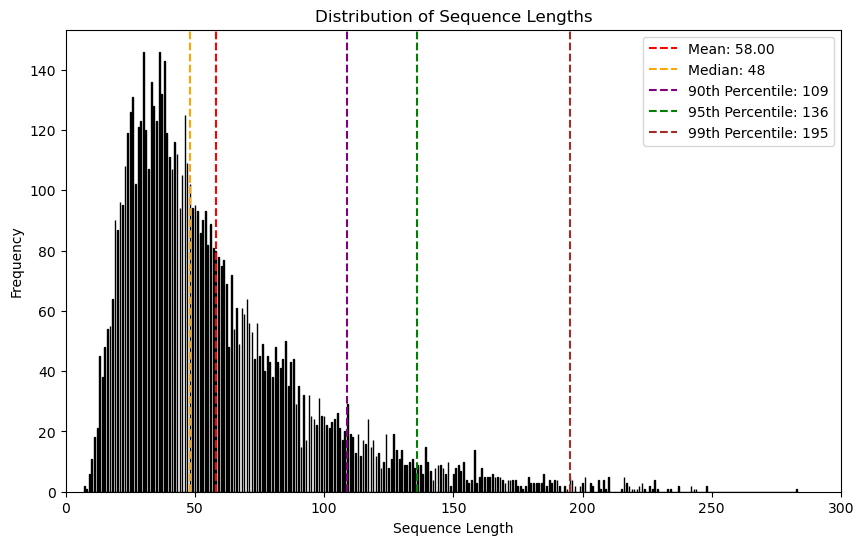

**<br>These metrics help determine optimal sequence and padding length to balance model efficiency and accuracy**.

In [32]:
# Calculate key metrics
display(Markdown("##### Key Metrics Of Sequences<br>"))
sequence_lengths = X_train.apply(len)
mean_length = int(np.mean(sequence_lengths))
median_length = int(np.median(sequence_lengths))
percentile_90 = int(np.percentile(sequence_lengths, 90))
percentile_95 = int(np.percentile(sequence_lengths, 95))
percentile_99 = int(np.percentile(sequence_lengths, 99))

print(f"{'Max Sequence Length':<25}{max(sequence_lengths):>4}")
print(f"{'Mean Sequence Length:':<25}{mean_length:>4}")
print(f"{'Median Sequence Length:':<25}{median_length:>4}")
print(f"{'90th Percentile Length:':<25}{percentile_90:>4}")
print(f"{'95th Percentile Length:':<25}{percentile_95:>4}")
print(f"{'99th Percentile Length:':<25}{percentile_99:>4}")

# Plot histogram while limiting the x-axis to 100
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=1000, edgecolor='black')
plt.axvline(mean_length, color='red', linestyle='dashed', 
            linewidth=1.5, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='orange', linestyle='dashed', 
            linewidth=1.5, label=f'Median: {median_length}')
plt.axvline(percentile_90, color='purple', linestyle='dashed', 
            linewidth=1.5, label=f'90th Percentile: {percentile_90}')
plt.axvline(percentile_95, color='green', linestyle='dashed', 
            linewidth=1.5, label=f'95th Percentile: {percentile_95}')
plt.axvline(percentile_99, color='brown', linestyle='dashed', 
            linewidth=1.5, label=f'99th Percentile: {percentile_99}')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.xlim(0, 300)
plt.legend()
plt.show()
display(Markdown("**<br>These metrics help determine optimal sequence and padding length to balance model \
efficiency and accuracy**."))

In [33]:
# Pad vectorized data
display(Markdown("##### Padded Data<br>"))
max_length = percentile_90
# max_length = percentile_99

def pad_and_truncate(sequences, max_length):
    # Convert to tensors and process
    sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    truncated = [seq[:max_length] for seq in sequences]
    padded = pad_sequence(truncated, batch_first=True, padding_value=0)
    return padded[:, :max_length]

# Pad all sets
X_train_padded = pad_and_truncate(X_train, max_length)
X_valid_padded = pad_and_truncate(X_valid, max_length)
X_test_padded = pad_and_truncate(X_test, max_length)

print(f"{'Sequence Length':<19}{max_length:>3}\n")
print(f"Example: {X_train_padded[0]}")

display(Markdown("**<br>The chosen length of sequences is determined by that of the 90th percentile, which captures \
the majority of sequence lengths. This drastically reduces the sequence length used in the embedding layer. Padding \
is applied to the end of each sequence that doesn't reach the full truncated length and ensures consistent input \
dimensions for the PyTorch model.**"))

##### Padded Data<br>

Sequence Length    109

Example: tensor([ 314,  488,  554,    6,    9,  231,   29, 2152,   14,   12,   12,    1,
        1113,  303,  374,   44,    7,  321,    3,   57,   17, 1262,    9,   12,
         856,   40,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])


**<br>The chosen length of sequences is determined by that of the 90th percentile, which captures the majority of sequence lengths. This drastically reduces the sequence length used in the embedding layer. Padding is applied to the end of each sequence that doesn't reach the full truncated length and ensures consistent input dimensions for the PyTorch model.**

---
### Data Storage 
* **Preserve Processed Data:** Save copies of both normalized and preprocessed datasets for future use.  
* **Train/Validation/Test Set Archiving:** Store train, validation, and test data along with their corresponding indices.  
* **Data Loading:** Retrieve saved train, validation, and test datasets with associated indices for further analysis.  

In [35]:
# Save a copy of the dataframe
df.to_csv('airlines_reviews_preprocessed.csv', index=True)

In [36]:
# Save final results data sets
torch.save(X_train_padded, 'X_train.pt')
torch.save(X_valid_padded, 'X_valid.pt')
torch.save(X_test_padded, 'X_test.pt')
np.save('y_train.npy', y_train.astype(np.float32))
np.save('y_valid.npy', y_valid.astype(np.float32))
np.save('y_test.npy', y_test.astype(np.float32))
torch.save(train_idx, 'train_idx.pt')
torch.save(valid_idx, 'valid_idx.pt')
torch.save(test_idx, 'test_idx.pt')

In [37]:
# Load data sets
X_train = torch.load('X_train.pt')
X_valid = torch.load('X_valid.pt')
X_test = torch.load('X_test.pt')
y_train = np.load('y_train.npy')
y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')
train_idx = torch.load('train_idx.pt')
valid_idx = torch.load('valid_idx.pt')
test_idx = torch.load('test_idx.pt')

display(Markdown("**<br>The above pipeline systematically prepares textual data for a PyTorch \
neural network model capable of making binary sentiment predictions on unseen data.**"))

**<br>The above pipeline systematically prepares textual data for a PyTorch neural network model capable of making binary sentiment predictions on unseen data.**

## <br>Neural Network Model

In [39]:
# Utility functions
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataloaders for use in PyTorch neural network classifier
def create_dataloaders(X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size):
    train_dataset = TensorDataset(X_train, torch.from_numpy(y_train))
    valid_dataset = TensorDataset(X_valid, torch.from_numpy(y_valid))
    test_dataset = TensorDataset(X_test, torch.from_numpy(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # For training
    train_loader_eval = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # For evaluation
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    valid_loader_eval = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)  # For evaluation
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, train_loader_eval, valid_loader, valid_loader_eval, test_loader

# Airline review classifier class (Tam, 2023)
class AirlineReviewClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, units_layer1=100, 
                 units_layer2=50, dropout_rate=0.5, best_config=None):
        super().__init__()
        
        if best_config is not None:
            embedding_dim = best_config['module__embedding_dim']
            units_layer1 = best_config['module__units_layer1']
            units_layer2 = best_config['module__units_layer2']
            dropout_rate = best_config['module__dropout_rate']

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dense1 = nn.Linear(embedding_dim, units_layer1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dense2 = nn.Linear(units_layer1, units_layer2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.output = nn.Linear(units_layer2, 1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, X):
        embedded = self.embedding(X)
        pooled = self.pool(embedded.permute(0, 2, 1)).squeeze(2)
        x = torch.relu(self.dense1(pooled))
        x = self.dropout1(x)
        x = torch.relu(self.dense2(x))
        x = self.dropout2(x)
        return torch.sigmoid(self.output(x)).squeeze(1)
    
    def predict(self, X):
        with torch.no_grad():
            return self.forward(X).round()

---
### Hyperparameter Tuning  
* **Parameter Exploration:** Investigate different hyperparameter values to optimize model performance.  
* **Optimal Hyperparameter Selection:** Identify and display the best-performing hyperparameters based on evaluation criteria. 

In [41]:
# Train a neural network and determine the best model parameters
display(Markdown("##### Optimal Hyperparameters<br>"))
vocab_size = int(X_train.max()) + 1
device = get_device()

# Training setup
def f1_eval(net, X, y):
    y_pred = net.predict(X).round()
    return f1_score(y, y_pred)

# Training setup using skorch
f1_cb = EpochScoring(f1_eval, name='valid_f1', lower_is_better=False, on_train=False)
early_stop = EarlyStopping(monitor='valid_f1', patience=3, lower_is_better=False)

model = NeuralNetClassifier(
    module = AirlineReviewClassifier,
    module__vocab_size = vocab_size,
    criterion = nn.BCELoss,
    optimizer = torch.optim.Adam,
    optimizer__weight_decay = 1e-4,
    batch_size = 64,
    max_epochs = 20,
    train_split=predefined_split(TensorDataset(X_valid, torch.from_numpy(y_valid))),
    callbacks=[f1_cb, early_stop],
    device=device,
    verbose=0)

# Parameter Grid
param_grid = {
    'module__embedding_dim': [64, 128, 256],
    'module__units_layer1': [50, 100, 150],
    'module__units_layer2': [20, 50, 100],
    'module__dropout_rate': [0.3, 0.5, 0.7],
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [16, 32]}

# Grid Search
start_time = time.time()
grid = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'f1',
    cv = 3,
    n_jobs = 1)

grid.fit(X_train, y_train)

# Time duration
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)

# Display best results
best_config = grid.best_params_
best_score = grid.best_score_

print(f"{'Best F1 Score:':<20}{best_score*100:>6.2f}\n")
print(f"{'Embedding Dim:':<20}{best_config['module__embedding_dim']:>3}")
print(f"{'Dense Layer 1:':<20}{best_config['module__units_layer1']:>3}")
print(f"{'Dense Layer 2:':<20}{best_config['module__units_layer2']:>3}")
print(f"{'Dropout Rate:':<20}{best_config['module__dropout_rate']:>6.2f}")
print(f"{'Learning Rate:':<20}{best_config['lr']:>7.3f}")
print(f"{'Batch Size:':<20}{best_config['batch_size']:>3}\n")
print(f"Grid search completed in {int(hours)} hours, {int(minutes)} minutes, and {int(seconds)} seconds.")

# Save Model
best_model = grid.best_estimator_
torch.save(best_model.module_.state_dict(), 'best_model.pt')

##### Optimal Hyperparameters<br>

Best F1 Score:       89.97

Embedding Dim:       64
Dense Layer 1:      100
Dense Layer 2:       20
Dropout Rate:         0.70
Learning Rate:        0.001
Batch Size:          32

Grid search completed in 2 hours, 7 minutes, and 50 seconds.


---
### Model Training  
* **Optimized Training Execution:** Train the model using the best-performing hyperparameters.  
* **Model Fitting:** Apply the model to the dataset for learning and refinement.  
* **Performance Summary:** Display key results and insights from the training process.  

##### <br>Training With Optimal Hyperparameters<br>

Epoch 1/20:
Train Loss: 0.6908 | Valid Loss: 0.6838
Valid F1: 0.6911 | Valid Acc: 0.5748
--------------------------------------------------
Validation F1 improved. Saving model to best_model.pt
Epoch 2/20:
Train Loss: 0.6847 | Valid Loss: 0.6700
Valid F1: 0.7156 | Valid Acc: 0.6056
--------------------------------------------------
Validation F1 improved. Saving model to best_model.pt
Epoch 3/20:
Train Loss: 0.6288 | Valid Loss: 0.4873
Valid F1: 0.8390 | Valid Acc: 0.8196
--------------------------------------------------
Validation F1 improved. Saving model to best_model.pt
Epoch 4/20:
Train Loss: 0.5074 | Valid Loss: 0.4021
Valid F1: 0.8563 | Valid Acc: 0.8271
--------------------------------------------------
Validation F1 improved. Saving model to best_model.pt
Epoch 5/20:
Train Loss: 0.4260 | Valid Loss: 0.3242
Valid F1: 0.8861 | Valid Acc: 0.8794
--------------------------------------------------
Validation F1 improved. Saving model to best_model.pt
Epoch 6/20:
Train Loss: 0.3889

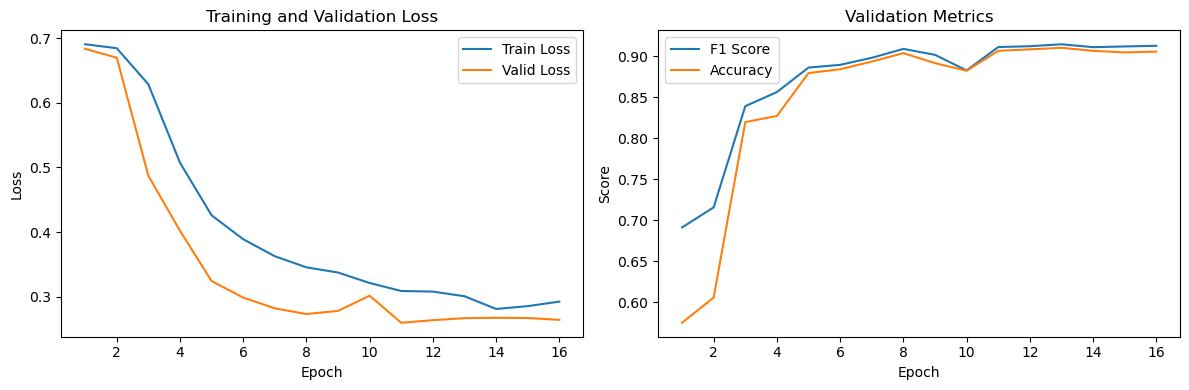

In [43]:
# Training with best parameters
display(Markdown("##### <br>Training With Optimal Hyperparameters<br>"))

def train_model(model, train_loader, valid_loader, criterion, optimizer, device, epochs=20, patience=3,
    model_save_path='best_model.pt'):
    best_f1 = 0
    patience_counter = 0
    history = {'train_loss': [], 'valid_loss': [], 'valid_f1': [], 'valid_acc': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        valid_preds = []
        valid_true = []
        valid_loss = 0
        
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                valid_loss += loss.item()
                valid_preds.extend(outputs.cpu().numpy())
                valid_true.extend(y_batch.cpu().numpy())
        
        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        valid_loss_avg = valid_loss / len(valid_loader)
        valid_preds = (np.array(valid_preds) > 0.5).astype(int)
        f1 = f1_score(valid_true, valid_preds)
        acc = accuracy_score(valid_true, valid_preds)
        
        # Update history
        history['train_loss'].append(train_loss_avg)
        history['valid_loss'].append(valid_loss_avg)
        history['valid_f1'].append(f1)
        history['valid_acc'].append(acc)
        
        # Print progress
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss_avg:.4f} | Valid Loss: {valid_loss_avg:.4f}')
        print(f'Valid F1: {f1:.4f} | Valid Acc: {acc:.4f}')
        print('-' * 50)
        
        # Early Stopping
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Validation F1 improved. Saving model to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement!")
                break
    
    return history

# Initialize model, criterion, and optimizer
vocab_size = int(X_train.max()) + 1
device = get_device()
model = AirlineReviewClassifier(vocab_size=vocab_size, best_config=best_config).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_config['lr'], weight_decay=1e-4)

# Create dataLoaders
train_loader, train_loader_eval, valid_loader, valid_loader_eval, test_loader = create_dataloaders(
    X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=best_config['batch_size'])

# Train the model
history = train_model(model=model, train_loader=train_loader, valid_loader=valid_loader, 
                      criterion=criterion, optimizer=optimizer, device=device, epochs=20, patience=3)

# Plot metrics over the course of the training
epochs_range = range(1, len(history['valid_f1']) + 1) # Create x-axis range starting at 1 instead of 0
print()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['valid_loss'], label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['valid_f1'], label='F1 Score')
plt.plot(epochs_range, history['valid_acc'], label='Accuracy')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

#### Model Performance Analysis
Based on the training data, the sentiment analysis model shows strong performance gains early in its training. The model rapidly improves, with validation F1 scores and accuracy consistently increasing as loss decreases, demonstrating reliable classification performance.

Early on, the model quickly refines its predictions, as indicated by the rapidly decreasing validation loss. It reaches a validation F1 score of 71.56% by Epoch 2 and surpasses 85% by Epoch 4 (specifically 85.63%). The model achieves an F1 score above 90% by Epoch 8 and continues to improve, reaching a peak of 91.46% in Epoch 13.

The validation loss reaches its minimum at Epoch 11, with a value of 0.2596, but the best F1 score and accuracy are achieved in a later epoch. The model's accuracy peaks at 91.03% in Epoch 13, showing it reached an optimized state for classification at this point. After Epoch 13, the model's performance on the validation set plateaus or slightly decreases, indicating the onset of overfitting.

The early stopping mechanism activates at Epoch 16, after three consecutive epochs without an improvement in the validation F1 score. This correctly halts the training process, preventing the model from continuing to overfit. The final saved model will be the one from Epoch 13, as it achieved the highest F1 score and accuracy. The results suggest the model effectively balances precision and recall, making it a stable and reliable tool for sentiment analysis.

## <br>Performance Assessment

In [46]:
# Model evaluation using batch processing
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_true = []
    all_outputs = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)

            preds = (outputs > 0.5).float()
            correct_predictions += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_true.extend(y_batch.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    f1 = f1_score(all_true, all_preds)

    return avg_loss, accuracy, f1, np.array(all_preds), np.array(all_outputs)

---
### Classification Report  
* **Test Data Predictions:** Generate predictions using the trained model on the test dataset.  
* **Performance Summary:** Display a classification report detailing precision, recall, and F1-scores.  
* **Evaluation Metrics:** Present key test set evaluation scores to assess overall model performance.  

In [48]:
# Show classification report and evaluation scores
device = next(model.parameters()).device
model = AirlineReviewClassifier(vocab_size=vocab_size, best_config=best_config).to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
score = evaluate_model(model, test_loader, criterion, device)

# Convert predictions to sentiment labels
sentiment = {0: "Negative", 1: "Positive"}
predicted = [sentiment[pred] for pred in score[3]]
actual = [sentiment[actual] for actual in y_test]

display(Markdown("##### Sample Predictions<br>"))
print(f"{'Reviews':<11}{'Predict':<13}{'Actual':<13}{'Match'}")
print('-'*42)
for i in range(10):
    print(f"{i:^7}{'    '}", end='')
    print(f"{predicted[i]:<13}", end='')
    print(f"{actual[i]:<13}", end='')
    print(f"{predicted[i] == actual[i]}")

display(Markdown("##### <br>Classification Report<br>"))
print(classification_report(y_test, score[3]))
print(f"Accuracy:  {score[1]:.4f}")
print(f"F1 Score:  {score[2]:.4f}")

##### Sample Predictions<br>

Reviews    Predict      Actual       Match
------------------------------------------
   0       Negative     Negative     True
   1       Negative     Negative     True
   2       Positive     Positive     True
   3       Negative     Negative     True
   4       Positive     Positive     True
   5       Negative     Negative     True
   6       Positive     Positive     True
   7       Negative     Negative     True
   8       Positive     Positive     True
   9       Positive     Positive     True


##### <br>Classification Report<br>

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88      1003
         1.0       0.92      0.87      0.89      1171

    accuracy                           0.89      2174
   macro avg       0.89      0.89      0.89      2174
weighted avg       0.89      0.89      0.89      2174

Accuracy:  0.8859
F1 Score:  0.8913


#### Model Performance by Sentiment Label
The model shows strong overall performance on the test data. The dataset has a modest sentiment label imbalance, with 1003 reviews for the negative sentiment label (0.0) and 1171 for the positive sentiment label (1.0). The overall accuracy is 0.8859 and the F1-score is 0.8913.

The model exhibits a specific pattern of performance across the sentiment labels. For the negative label, it achieves a precision of 0.86 and a recall of 0.91. This indicates that while the model is very good at identifying negative reviews (correctly classifying 91% of them), it is less precise in its negative predictions (only 86% of its negative predictions are correct). This suggests it sometimes mislabels positive reviews as negative.

Conversely, for the positive label, the model achieves a high precision of 0.92 but a slightly lower recall of 0.87. This shows a slight bias towards minimizing false positives for the positive label. The model is highly accurate when it predicts a review is positive (92% of the time), but it only correctly identifies 87% of all truly positive reviews.

Despite these nuances, the model still generalizes effectively to unseen data. Its strong F1-score confirms it is well-optimized for sentiment analysis, providing dependable insights into passenger sentiment.

---
### ROC Curve and AUC Score
* **Threshold-Agnostic Evaluation:** Assess model performance across all classification thresholds using ROC analysis.
* **Visualization:** Plot the ROC Curve to visualize trade-offs between true positive and false positive rates.
* **Discriminative Power:** Compute the AUC to quantify the classifier's ability to distinguish between classes.

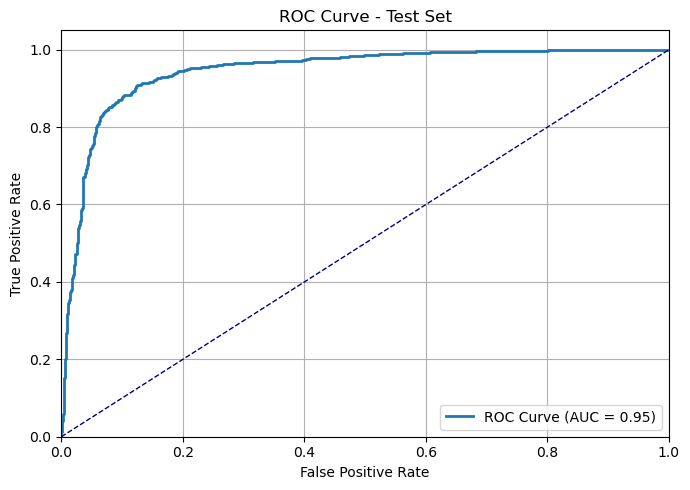

In [51]:
# Compute ROC metrics
y_probs = score[4]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The AUC-ROC score of 0.95 indicates strong discriminative capability, aligning with earlier performance metrics. The curve’s early rise and proximity to the top-left corner reflect high true positive rates with minimal false positives, underscoring the model’s reliability across varying threshold values.

---
### Confusion Matrix  
* **Visualization:** Generate and plot the confusion matrix to analyze classification accuracy.  
* **Performance Evaluation:** Compute key metrics such as precision, recall, and F1-score based on the confusion matrix.  

##### Confusion Matrix<br>

##### Overall Performance Metrics


Accuracy:      88.59%
Precision:     91.54%
Recall:        86.85%
Specificity:   90.63%




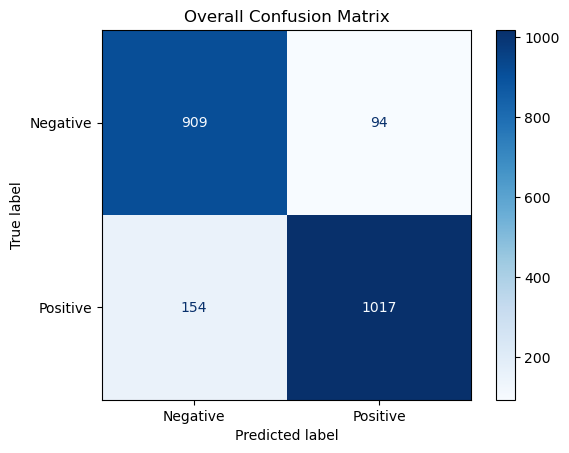

In [54]:
# Plot the confusion matrix
display(Markdown("##### Confusion Matrix<br>"))
device = next(model.parameters()).device
X_test = X_test.to(device)  # Move test data to the correct device
y_pred = model.predict(X_test)
y_pred = y_pred.cpu().numpy()  # Transfer predictions to CPU

def print_metrics(y_true, y_pred, class_name="Overall"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    
    display(Markdown(f"##### {class_name} Performance Metrics\n"))
    print(f"{'Accuracy:':<15}{accuracy * 100:.2f}%")
    print(f"{'Precision:':<15}{precision * 100:.2f}%")
    print(f"{'Recall:':<15}{recall * 100:.2f}%")
    print(f"{'Specificity:':<15}{specificity * 100:.2f}%\n\n")

def plot_confusion_matrix(y_true, y_pred, class_name="Overall"):
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    cm_display.plot(cmap='Blues')
    plt.title(f"{class_name} Confusion Matrix")
    plt.show()

print_metrics(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

#### Overall Performance Metrics
The sentiment analysis model demonstrates strong performance across multiple evaluation metrics. Its overall accuracy of 88.59% indicates it correctly classifies sentiment in the vast majority of cases. The overall precision is 91.54% and the overall recall is 86.85%.

#### Confusion Matrix Analysis
The confusion matrix provides a detailed view of this performance. Out of a total of 2,174 reviews, the model:
* Correctly identified 1,017 true positives (positive reviews correctly classified as positive) and 909 true negatives (negative reviews correctly classified as negative).
* Made 94 false positive errors (negative reviews incorrectly classified as positive).
* Made 154 false negative errors (positive reviews incorrectly classified as negative).

#### Specific Metric Insights
The model's precision of 91.54% indicates a low rate of false positives, ensuring that when the model predicts a positive review, it's highly likely to be correct. The specificity of 90.63% highlights its strong ability to correctly identify negative reviews.

The recall of 86.85% confirms the model effectively recognizes most positive reviews. The lower recall relative to precision suggests the model is slightly more prone to missing a positive review than to incorrectly labeling a negative one.

Collectively, these metrics and the confusion matrix confirm that the model is well-suited for evaluating passenger sentiment, offering dependable insights into classification trends with a strong emphasis on precision and accuracy.

---
### Model Evaluation  
* **Training Set Metrics:** Assess loss, accuracy, and F1 score on the training data.  
* **Testing Set Metrics:** Evaluate model performance on unseen test data.

In [57]:
# Evaluate the model for training and testing data
display(Markdown("##### Test Set Evaluation<br>"))
model.eval()

score = evaluate_model(model, train_loader_eval, criterion, device)
print(f"{'Training Loss':<21}{score[0]*100:5.2f}%")
print(f"{'Training Accuracy':<21}{score[1]*100:5.2f}%")
print(f"{'Training F1 Score':<21}{score[2]*100:5.2f}%", end='\n\n')

score = evaluate_model(model, valid_loader_eval, criterion, device)
print(f"{'Validation Loss':<21}{score[0]*100:5.2f}%")
print(f"{'Validation Accuracy':<21}{score[1]*100:5.2f}%")
print(f"{'Validation F1 Score':<21}{score[2]*100:5.2f}%", end='\n\n')

score = evaluate_model(model, test_loader, criterion, device)
print(f"{'Testing Loss':<21}{score[0]*100:5.2f}%")
print(f"{'Testing Accuracy':<21}{score[1]*100:5.2f}%")
print(f"{'Testing F1 Score':<21}{score[2]*100:5.2f}%")

##### Test Set Evaluation<br>

Training Loss        21.27%
Training Accuracy    93.51%
Training F1 Score    93.87%

Validation Loss      26.16%
Validation Accuracy  91.03%
Validation F1 Score  91.46%

Testing Loss         30.00%
Testing Accuracy     88.59%
Testing F1 Score     89.13%


#### Model Performance and Overfitting
Based on the metrics, the model shows some signs of overfitting, though its overall performance remains strong. The performance gap between the training set and the test set is a key indicator of this.

Accuracy: There is a 4.92% drop from the training accuracy of 93.51% to the testing accuracy of 88.59%.

F1 Score: The 4.74% drop from the training F1 score of 93.87% to the testing F1 score of 89.13% reinforces the observation.

Loss: The gap in loss is the most significant indicator. Training loss is 21.27%, while testing loss is 30.00%, a difference of 8.73 percentage points.

The general rule is that a model should perform slightly better on the training data than on unseen data, but a large gap suggests that the model has learned the training data "too well" and is less effective at generalizing to new examples. This is the definition of overfitting.

While the model exhibits a degree of overfitting, it still performs very well on the test set, with an accuracy of nearly 89% and a strong F1 score. This indicates that despite the drop in performance, the model is still robust and highly effective for sentiment analysis.

## <br>Prediction Analysis

In [60]:
class_order = ['Economy', 'Premium', 'Business', 'First']
type_order = ['Solo', 'Couple', 'Family', 'Professional']
ordered_cols = ['Mean', 'Median', 'SD', 'MAD', 'IQR', 'Variability', 'Accuracy', 'Size']

# Prediction logger class
class PredictionLogger:
    def __init__(self, original_df=None, metadata_cols=None):
        self.results = pd.DataFrame(columns=[
            'Index',
            'Actual',
            'Predicted',
            'Correct',
            'Output'])
        self.original_df = original_df
        self.metadata_cols = metadata_cols

    # Add prediction results to dataframe
    def add_batch(self, y_true, y_pred, outputs, indices):
        batch = pd.DataFrame({
            'Index': indices,
            'Actual': y_true,
            'Predicted': y_pred,
            'Correct': (y_pred == y_true),
            'Output': outputs}, index=indices)
        
        if self.original_df is not None and self.metadata_cols:
            batch = batch.join(self.original_df[self.metadata_cols])
            
        self.results = pd.concat([self.results, batch])

    # Retrieve and save data
    def get_correct_preds(self):
        return self.results[self.results['Correct']]

    def get_incorrect_preds(self):
        return self.results[~self.results['Correct']]

    def get_all_preds(self):
        return self.results
    
    def save_preds(self, path):
        self.results.to_csv(path, index=False, header=True)

# Load saved preprocessed dataset
df_preproc = pd.read_csv('airlines_reviews_preprocessed.csv', index_col=0)

logger = PredictionLogger(df_preproc, ['Class', 'Type'])
logger.add_batch(y_test, score[3], score[4], test_idx)

# Save prediction data
logger.save_preds('airlines_reviews_predictions.csv')

# Prepare results dataframe
df_pred = logger.get_all_preds()
df_pred['Type'] = df_pred['Type'].replace('Business', 'Professional')

---
### Misclassification  
* **By Seating Class:** Calculates the count and percentage of misclassified sentiments.  
* **By Passenger Type:** Calculates the count and percentage of misclassified sentiments.

In [62]:
# Calculate misclassifications
def misclassification_by_class(df, segment_col, order, title):
    display(Markdown(f"##### Misclassification by {title}<br>"))
    segment_count = df[segment_col].value_counts()
    misclassified = df[df['Correct'] == False]
    total = len(df)
    
    counts = misclassified[segment_col].value_counts()
    percentages = (counts / segment_count * 100).round(2)
    
    result = pd.DataFrame({
        'Count': segment_count,
        'Misclassified': counts,
        'Percentage (%)': percentages})

    result = result.reindex(order)
    
    return result

print(misclassification_by_class(df_pred, 'Class', class_order, 'Seating Class'), end='\n\n')
print(misclassification_by_class(df_pred, 'Type', type_order, 'Passenger Type'))

##### Misclassification by Seating Class<br>

          Count  Misclassified  Percentage (%)
Class                                         
Economy    1459            159           10.90
Premium     109             14           12.84
Business    568             71           12.50
First        38              4           10.53



##### Misclassification by Passenger Type<br>

              Count  Misclassified  Percentage (%)
Type                                              
Solo            867            103           11.88
Couple          530             60           11.32
Family          416             39            9.38
Professional    361             46           12.74


#### Seating Class
Based on the provided data, the model's misclassification rates vary across seating classes.

Premium Class has the highest misclassification rate at 12.84% (14 out of 109). This suggests the model finds this class the most challenging to classify correctly.

Business Class follows with a misclassification rate of 12.50% (71 out of 568).

Economy Class has a misclassification rate of 10.90% (159 out of 1459).

First Class has the lowest misclassification rate at 10.53% (4 out of 38), indicating the model is most accurate with this group.

#### Passenger Type
The model's performance also varies by passenger type.

Professional travelers have the highest misclassification rate at 12.74% (46 out of 361).

Solo travelers follow closely with a rate of 11.88% (103 out of 867).

Couple travelers have a misclassification rate of 11.32% (60 out of 530).

Family travelers have the lowest misclassification rate at 9.38% (39 out of 416), suggesting their sentiment is the most distinct and easiest for the model to classify.

---
### Normality Assessment  
* **Histogram Analysis:** Visualizes the distribution of passenger satisfaction scores.  
* **Shapiro-Wilk Test:** Statistically tests for normality.

##### Distribution Normality<br>

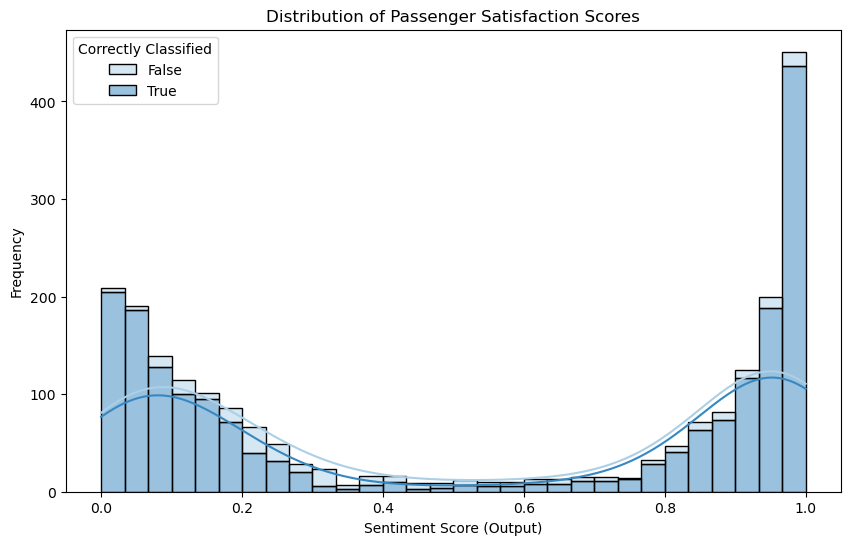

Shapiro-Wilk Test p-value: 0.0000
Data is significantly non-normal.


In [66]:
# Determine if data in 'Output' is normally distributed
display(Markdown("##### Distribution Normality<br>"))
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_pred, x='Output', hue='Correct', multiple='stack', bins=30, kde=True, palette='Blues')
sns.move_legend(ax, "upper left", title="Correctly Classified")
plt.title("Distribution of Passenger Satisfaction Scores")
plt.xlabel("Sentiment Score (Output)")
plt.ylabel("Frequency")
plt.show()

shapiro_test = shapiro(df_pred['Output'])
print(f"Shapiro-Wilk Test p-value: {shapiro_test.pvalue:.4f}")

if shapiro_test.pvalue < 0.05:
    print("Data is significantly non-normal.")
else:
    print("Data appears normally distributed.")

The Shapiro-Wilk test results show that the dataset does not follow a normal distribution, with a p-value less than 0.05 strongly rejecting the null hypothesis of normality. This confirms that the data is significantly non-normal, as illustrated in the distribution graph. The shape of the distribution supports this conclusion, showing clear deviations from a normal curve. Since normality is a key assumption for certain statistical tests, a Kruskal-Wallis test will be used instead of ANOVA. The Kruskal-Wallis test is more appropriate because it compares medians rather than means and is better suited for handling skewed, non-normal, or multimodal data distributions. This approach ensures more reliable results when evaluating differences between groups in the dataset.

---
### Statistical Significance
* **Kruskal-Wallis Test:** Perform the Kruskal-Wallis test to evaluate differences between multiple independent groups.
* **Dunn's Test:** Conduct Dunn's post-hoc test to determine pairwise differences following a significant Kruskal-Wallis result.

##### Significance by Seating Class:

Kruskal-Wallis Test p-value: 0.00000
Significant differences exist among seating class.

Dunn’s Test:
          Economy  Premium  Business    First
Economy   1.00000  1.00000   0.00000  0.00039
Premium   1.00000  1.00000   0.00018  0.02244
Business  0.00000  0.00018   1.00000  1.00000
First     0.00039  0.02244   1.00000  1.00000



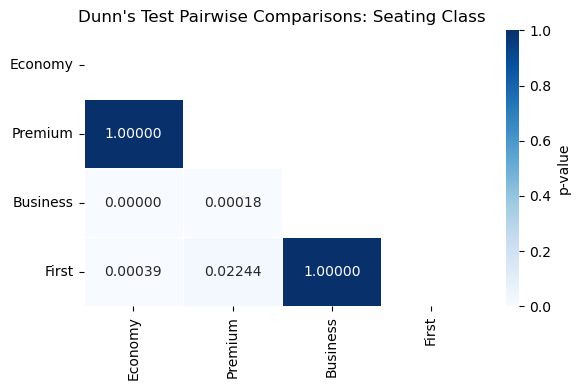

##### Significance by Passenger Type:

Kruskal-Wallis Test p-value: 0.00000
Significant differences exist among passenger type.

Dunn’s Test:
                 Solo   Couple   Family  Professional
Solo          1.00000  0.00029  0.00001       0.36435
Couple        0.00029  1.00000  1.00000       0.71167
Family        0.00001  1.00000  1.00000       0.13449
Professional  0.36435  0.71167  0.13449       1.00000



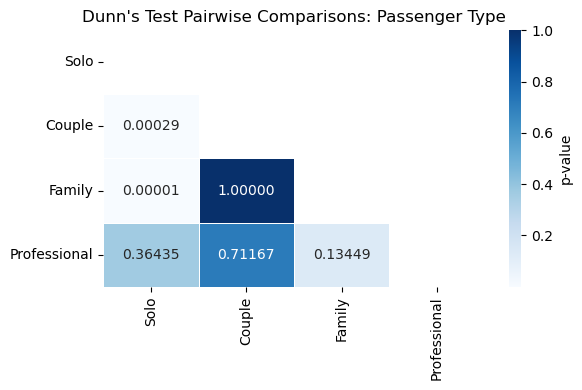

In [69]:
# Kruskal-Wallis and Dunn's Test
def run_statistical_tests(df, group_col, order, title):
    # Kruskal-Wallis Test
    groups = [df[df[group_col] == value]['Output'] for value in df[group_col].unique()]
    kruskal_test = kruskal(*groups)

    display(Markdown(f"##### Significance by {title}:"))
    print(f"Kruskal-Wallis Test p-value: {kruskal_test.pvalue:.5f}")
    if kruskal_test.pvalue < 0.05:
        print(f"Significant differences exist among {title.lower()}.")
    else:
        print("No significant difference found.")

    # Dunn's test and reorder results
    dunn_results = posthoc_dunn(df, val_col='Output', group_col=group_col, p_adjust='bonferroni')

    if order:
        dunn_results = dunn_results.reindex(index=order, columns=order)
        
    dunn_results = dunn_results.applymap(lambda x: round(x, 5))

    print("\nDunn’s Test:")
    print(dunn_results, end="\n\n")
    
    # Plot the Dunn's test heatmap
    plt.figure(figsize=(6, 4))
    mask = np.triu(np.ones_like(dunn_results, dtype=bool)) # Mask to hide the upper triangle
    sns.heatmap(dunn_results, annot=True, fmt=".5f", cmap="Blues", center=0.5,
                cbar_kws={'label': 'p-value'}, linewidths=0.5,
                mask=mask)

    plt.title(f"Dunn's Test Pairwise Comparisons: {title}")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Seating Class
dunn_class = run_statistical_tests(df_pred, 'Class', class_order, "Seating Class")
print()
# Passenger Type
dunn_type = run_statistical_tests(df_pred, 'Type', type_order, "Passenger Type")

#### Seating Class
The Kruskal-Wallis test confirms statistically significant differences in passenger sentiment across seating classes (p = 0.00000), indicating that seating choice meaningfully influences experience.

Dunn’s test:
- Economy sentiment is statistically indistinct from Premium (p = 1.00000) but significantly different (with p-values less than 0.05) from Business (p = 0.00000) and First-class (p = 0.00039).
- Premium sentiment is significantly different from Business (p = 0.00018) and First-class (p = 0.02244).
- Business and First-class sentiment levels are statistically indistinct (p = 1.00000).

These results confirm a clear pattern of differentiation between the lower-tier and higher-tier classes. The sharpest contrast in sentiment occurs between the combined Economy/Premium tier and the Business-class tier. This suggests that the experience gap between a Premium and Business seat is more pronounced than between Economy and Premium.

#### Passenger Type
The Kruskal-Wallis test reveals statistically significant differences in passenger sentiment across passenger types (p = 0.00000), indicating that travel context, whether solo, with others, or for business, meaningfully influences the passenger experience.

Dunn’s test:
- Solo travelers show significantly different sentiment from both Couples (p = 0.00029) and Families (p = 0.00001), suggesting that traveling alone may be associated with a distinct emotional experience from those who travel with partners or families.
- Couples and Families exhibit statistically indistinct sentiment levels (p = 1.00000), implying similar emotional responses to the travel experience when accompanied.
- Business travelers are statistically indistinct (with p-values greater than 0.05) from Solo travelers (p = 0.36435), Couples (p = 0.71167), and Families (p = 0.13449), suggesting that sentiment among business passengers is more variable or less sharply differentiated.

These results suggest that companionship during travel plays a notable role in shaping sentiment. The most pronounced contrast is between Solo travelers and those accompanied (Couples or Families), with Solo passengers reporting significantly different sentiment. This may reflect differences in expectations, stress levels, or engagement with the travel environment.

Interestingly, Business travelers occupy a middle ground, not significantly different from any other group, which could indicate a more utilitarian or neutral sentiment profile, possibly driven by purposeful travel rather than leisure or companionship.

#### Combined Implications
The statistical evidence from both seating class and passenger type analyses points to meaningful differences in passenger experience across each dimension. However, the real insight emerges when these two are considered together: the combination of class and type likely shapes satisfaction in ways that neither dimension captures alone. For instance, while Business and First Class may appear similar in overall performance, the experience of a Solo traveler in First Class could differ substantially from that of a Family in the same tier, suggesting that passenger type modulates how class is perceived.

This reinforces the need for a dual-segmentation approach. Treating seating class and passenger type as intersecting factors allows for more precise targeting, tailored service strategies, and a clearer understanding of where inconsistencies or unmet expectations arise. The statistical significance across both dimensions justifies moving beyond isolated comparisons and toward a framework that accounts for their interaction.

---
### Descriptive Statistics
* **Mean:** Display barplot for Class and Type.
* **Quartile:** Display boxplot for Class, Type, and the combination of the two.  
* **Summary Table:** Report mean, median, standard deviation, MAD, IQR, sample size, and accuracy for each group.  

##### Statistics<br>

##### Seating Class:

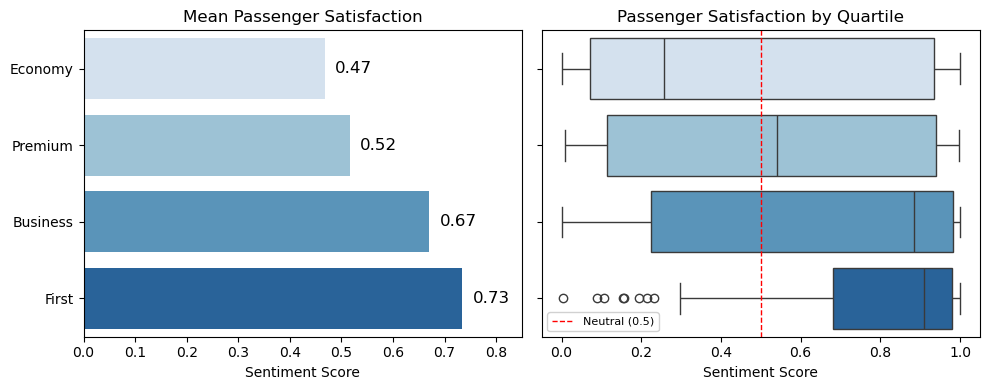


          Mean Median    SD   MAD   IQR Variability Accuracy  Size
Class                                                             
Economy   0.47   0.26  0.41  0.39  0.86        1.66     0.89  1459
Premium   0.52   0.54  0.40  0.38  0.83        1.60     0.87   109
Business  0.67   0.88  0.37  0.34  0.76        1.47     0.88   568
First     0.73   0.91  0.34  0.28  0.30        0.91     0.89    38




##### Passenger Type:

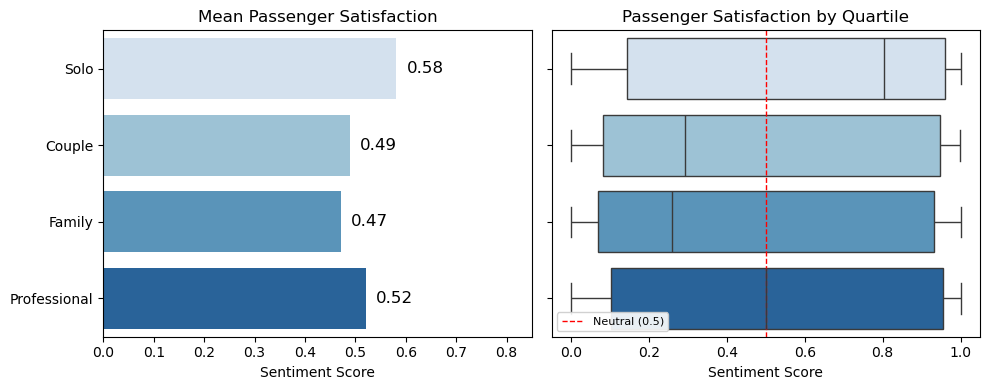


              Mean Median    SD   MAD   IQR Variability Accuracy  Size
Type                                                                  
Solo          0.58   0.80  0.40  0.38  0.82        1.60     0.88   867
Couple        0.49   0.29  0.41  0.40  0.87        1.67     0.89   530
Family        0.47   0.26  0.41  0.39  0.86        1.66     0.91   416
Professional  0.52   0.50  0.41  0.39  0.85        1.65     0.87   361



In [74]:
# Calculated statistics
display(Markdown("##### Statistics<br>"))

def plot_sentiment(df, group_col, title, order_list):
    display(Markdown(f"##### {title}:"))
    group_means = df.groupby(group_col)['Output'].mean().reindex(order_list).reset_index()
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # Bar chart (left)
    ax1 = sns.barplot(y=group_col, x='Output', data=group_means, palette='Blues', ax=axes[0])
    for index, row in group_means.iterrows():
        ax1.text(row['Output'] + 0.02, index, f"{row['Output']:.2f}",
                 color='black', va="center", fontsize=12)
    ax1.set_title("Mean Passenger Satisfaction")
    ax1.set_ylabel('')
    ax1.set_xlabel("Sentiment Score")
    ax1.set_xlim(0, 0.85)

    # Box plot (right)
    ax2 = sns.boxplot(y=group_col, x='Output', data=df, palette='Blues', ax=axes[1], order=order_list)
    neutral_line = ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=1, label='Neutral (0.5)')
    ax2.legend(handles=[neutral_line], loc='lower left', facecolor='white', fontsize=8, framealpha=0.9)
    ax2.set_title("Passenger Satisfaction by Quartile")
    ax2.set_xlabel("Sentiment Score")
    ax2.set_ylabel("")
    
    plt.tight_layout()
    plt.show()

def sentiment_stats(df, group_col, order):
    group_stats = df.groupby(group_col).agg(
        Mean=('Output', 'mean'),
        Median=('Output', 'median'),
        SD=('Output', 'std'),
        MAD=('Output', lambda x: (x - x.mean()).abs().mean()),
        IQR=('Output', lambda x: x.quantile(0.75) - x.quantile(0.25)),
        Size=('Correct', 'count'),
        Accuracy=('Correct', 'mean'))

    group_stats['Variability'] = (group_stats['SD'] + group_stats['MAD'] + group_stats['IQR'])

    # Reorder output
    if isinstance(group_col, list):
        order = pd.MultiIndex.from_product(order, names=group_col)

    group_stats = group_stats.reindex(order)
    group_stats = group_stats[ordered_cols]
    for col in ordered_cols[:-1]:
        group_stats[col] = group_stats[col].apply(lambda x: f"{x:.2f}")

    print(f"\n{group_stats.to_string()}", end='\n\n')

    return group_stats

# Seating Class
plot_sentiment(df_pred, 'Class', 'Seating Class', class_order)
class_stats = sentiment_stats(df_pred, 'Class', class_order)
print()
# Passenger Type
plot_sentiment(df_pred, 'Type', 'Passenger Type', type_order)
type_stats = sentiment_stats(df_pred, 'Type', type_order)

#### Seating Class
Passenger satisfaction tends to improve with higher-tier seating, though the differences across classes vary in both magnitude and consistency.

**Economy Class** shows the lowest average sentiment (Mean: 0.47), paired with the highest variability (MAD: 0.39, IQR: 0.86, Variability Index: 1.66), suggesting that while satisfaction is generally low, passenger experiences are highly inconsistent, ranging from very negative to moderately positive. The low median (0.26) reinforces the skew toward dissatisfaction.

**Premium Class** sentiment improves modestly (Mean: 0.52, Median: 0.54), but variability remains high and is nearly identical to that seen in Economy Class. This indicates that simply upgrading from Economy to Premium does not guarantee a more consistent experience.

**Business Class** marks a significant improvement in both satisfaction and consistency. The transition from Premium to Business Class marks the single largest jump in passenger satisfaction, with the mean sentiment increasing by 0.15 points and the median jumping by 0.34 points. With a higher Mean: 0.67 and Median: 0.88, passengers report more positive experiences overall. Variability drops notably (MAD: 0.34, IQR: 0.76, Variability Index: 1.47), indicating a more uniform sentiment profile. The median (0.88) is notably higher than the mean (0.67), indicating a left-skewed distribution. This suggests that while a small number of very dissatisfied passengers pull the average down, the clear majority of Business Class travelers are highly satisfied, with more than half rating their experience at 0.88 or above.

**First Class** stands out with the highest satisfaction (Mean: 0.73, Median: 0.91) and the lowest variability across all metrics (MAD: 0.28, IQR: 0.30, Variability Index: 0.91), reflecting a consistently positive experience with minimal deviation among passengers. It is critical to note that the First Class category has a very small sample size (Size: 38) compared to Economy (1459) or Business (568). While the data indicates very high and consistent satisfaction, the conclusions are drawn from a much smaller base, making them more susceptible to statistical noise.

#### Passenger Type
Passenger sentiment varies across travel contexts, with clear differences in both satisfaction levels and consistency.

**Solo** travelers report the highest average sentiment (Mean: 0.58), paired with moderate variability (MAD: 0.38, IQR: 0.82). This suggests that solo passengers generally have a positive experience, with a relatively stable emotional response across individuals.

**Couples** show lower sentiment (Mean: 0.49) and the highest variability (MAD: 0.40, IQR: 0.87). This indicates a more unpredictable experience, where satisfaction levels range widely. The elevated variability suggests that traveling as a couple may introduce factors that affect sentiment unevenly.

**Families** have the lowest average sentiment (Mean: 0.47), with high variability (MAD: 0.39, IQR: 0.86). This points to a generally less positive experience, with a wide spread of emotional responses. The similarity to the couple profile reinforces the idea that traveling with companions may lead to more complex or inconsistent experiences.

**Professionals** fall in the middle (Mean: 0.52), with slightly lower variability than Couples and Families (MAD: 0.39, IQR: 0.85). This suggests a more neutral or utilitarian experience, with sentiment levels that are neither highly polarized nor tightly clustered.

#### Summary Insight
Interestingly, the average Solo traveler (Mean: 0.58) reports higher satisfaction than the average Premium Class passenger (Mean: 0.52). This suggests that the social context of travel (i.e., traveling alone versus with others) can be a more powerful determinant of satisfaction than a cabin upgrade from Economy to Premium.

---
### Distribution Analysis  
* **KDE Plot Visualization:** Generate a Kernel Density Estimation (KDE) plot to assess the smooth distribution of passenger satisfaction.  
* **ECDF Representation:** Display an Empirical Cumulative Distribution Function (ECDF) plot to provide insight into satisfaction trends at different percentiles.  

##### Density And Accumulation Trends<br>

##### Seating Class:

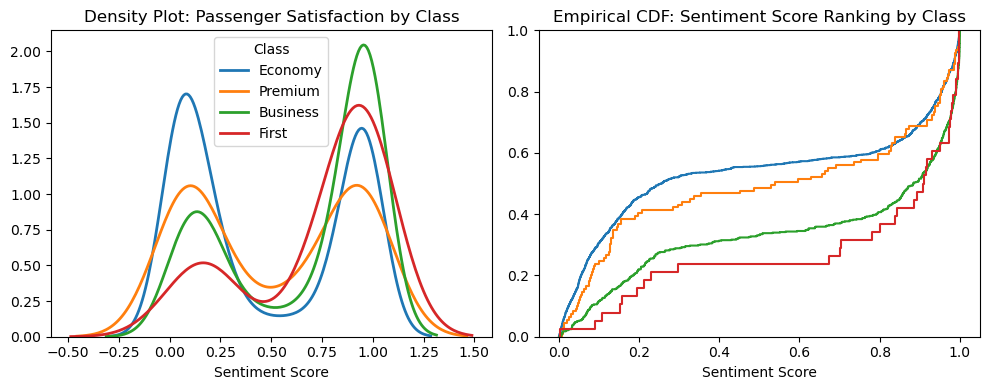

##### Passenger Type:

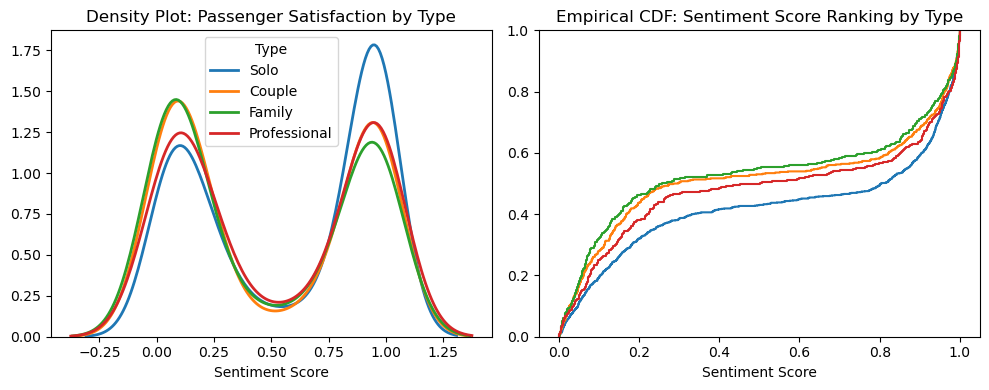

In [78]:
# Provide a KDE plot and an ECDF plot
display(Markdown("##### Density And Accumulation Trends<br>"))

def plot_sentiment_distributions(df, group_col, order, title):
    display(Markdown(f"##### {title}:"))
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # KDE Plot
    for cat in order:
        sns.kdeplot(df[df[group_col] == cat]['Output'], label=cat, linewidth=2, ax=axes[0])
    axes[0].set_title(f"Density Plot: Passenger Satisfaction by {group_col}")
    axes[0].set_xlabel("Sentiment Score")
    axes[0].set_ylabel('')
    axes[0].legend(title=group_col)

    # ECDF Plot
    for cat in order:
        sns.ecdfplot(df[df[group_col] == cat]['Output'], label=cat, ax=axes[1])
    axes[1].set_title(f"Empirical CDF: Sentiment Score Ranking by {group_col}")
    axes[1].set_xlabel("Sentiment Score")
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()
    print()

plot_sentiment_distributions(df_pred, 'Class', class_order, 'Seating Class')
plot_sentiment_distributions(df_pred, 'Type', type_order, 'Passenger Type')

#### Seating Class
The density plot and empirical CDF (ECDF) reveal distinct sentiment distributions across seating classes, illustrating how passenger satisfaction varies not only in magnitude but also in consistency.

**Economy Class** displays a bimodal distribution, with one prominent peak near 0 and a second, lower peak near 1. This indicates that a significant number of passengers report either very low or very high satisfaction. The ECDF curve for Economy rises sharply at lower sentiment scores, confirming a rapid accumulation of dissatisfaction before a slower rise towards higher scores.

**Premium Economy** shows a more balanced distribution, with two visible peaks in the density plot — one near 0 and another near 1.0. This suggests a polarized sentiment profile, where passengers tend to report either very low or very high satisfaction. The ECDF curve accumulates more gradually than Economy, indicating a shift toward higher sentiment scores and a more evenly distributed experience.

**Business Class** exhibits a clear skew toward high satisfaction. The density plot shows a modest peak around 0.25 and a dominant peak at 1.0, suggesting that while some passengers report lower sentiment, the majority experience high satisfaction. The ECDF curve rises slowly at first and then accelerates near the upper sentiment range, confirming this upward shift.

**First Class** presents the most concentrated and positively skewed distribution. The density plot features a sharp, singular peak at 1.0 with minimal presence elsewhere, indicating that nearly all passengers report top-tier satisfaction. The ECDF curve is the flattest at the lower end and steepest near 1.0, confirming that very few passengers report low sentiment scores.

These visualizations reinforce the conclusion that higher-tier seating correlates with more uniformly positive sentiment, both in magnitude and distribution. The ECDF curves, in particular, highlight how the probability of low sentiment drops sharply as seating class improves.

#### Passenger Type
The density plot and empirical CDF (ECDF) reveal distinct sentiment patterns across passenger types, highlighting how travel context shapes emotional experience.

**Solo** travelers show the most concentrated and positively skewed sentiment distribution. The density plot features a dominant peak around 0.75, indicating that most Solo passengers report high satisfaction. The ECDF curve rises slowly at lower sentiment scores and accelerates near the top end, confirming that negative sentiment is relatively rare in this group.

**Couples** display a more polarized distribution. The density plot shows two visible peaks, one near 0.25 and another near 0.75, suggesting that sentiment is split between low and high satisfaction levels. The ECDF curve rises steeply at the lower end, indicating that a substantial portion of Couples report low sentiment scores, though a secondary rise near the upper range reflects a mix of positive experiences.

**Families** mirror the sentiment profile of Couples, with a strong density peak near 0.25 and a smaller rise near 0.75. This suggests that family travel is more prone to dissatisfaction, with fewer passengers reporting high satisfaction. The ECDF curve confirms this, showing rapid accumulation at low sentiment scores and slower growth near the top.

**Professionals** present a more balanced sentiment distribution. The density plot shows a broad rise from 0.25 to 0.75, without sharp peaks, indicating a mix of experiences without strong clustering. The ECDF curve rises steadily across the sentiment range, suggesting that Business passengers report a wide spectrum of satisfaction levels, neither predominantly negative nor overwhelmingly positive.

These visualizations reinforce the idea that travel context significantly influences passenger sentiment, with Solo travelers experiencing the most reliably positive outcomes and Families facing the greatest variability in satisfaction.

## <br>Combined Analysis
* **Descriptive Statistics:** Calculate and present descriptive statistics for the combined groups.
* **Distribution Analysis:** Visually analyze the distribution of sentiment scores for the combined groups.
* **Overall Trends Table:** Summarize which passenger types are the most and least satisfied within each seating class.

##### Combined Statistics<br>

##### Combined:

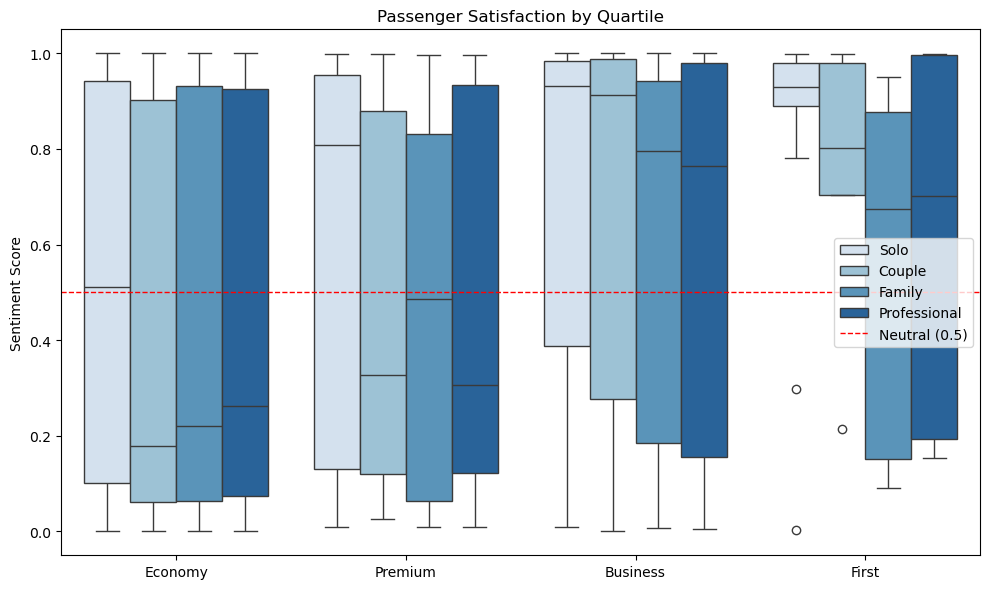


                       Mean Median    SD   MAD   IQR Variability Accuracy  Size
Class    Type                                                                  
Economy  Solo          0.52   0.51  0.40  0.39  0.84        1.63     0.89   596
         Couple        0.41   0.18  0.40  0.38  0.84        1.62     0.90   360
         Family        0.44   0.22  0.41  0.39  0.87        1.67     0.91   335
         Professional  0.46   0.26  0.41  0.39  0.85        1.65     0.84   168
Premium  Solo          0.59   0.81  0.40  0.37  0.82        1.59     0.85    40
         Couple        0.48   0.33  0.39  0.36  0.76        1.51     0.79    39
         Family        0.45   0.49  0.41  0.36  0.77        1.54     1.00    11
         Professional  0.48   0.31  0.42  0.39  0.81        1.62     1.00    19
Business Solo          0.74   0.93  0.34  0.29  0.60        1.22     0.86   212
         Couple        0.71   0.91  0.36  0.32  0.71        1.40     0.89   126
         Family        0.61   0.80  0.3

In [82]:
# Calculated combined statistics
display(Markdown("##### Combined Statistics<br>"))
display(Markdown("##### Combined:"))
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_pred, x='Class', y='Output', hue='Type', palette='Blues',
                 order=class_order, hue_order=type_order)
neutral_line = ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
handles, labels = ax.get_legend_handles_labels()
handles.append(neutral_line)
labels.append('Neutral (0.5)')
ax.legend(handles=handles, labels=labels, loc='center right')

# Final formatting
plt.title('Passenger Satisfaction by Quartile')
plt.xlabel('')
plt.ylabel('Sentiment Score')
plt.tight_layout()
plt.show()

comb_stats = sentiment_stats(df_pred, ['Class', 'Type'], [class_order, type_order])

#### Combined Analysis
Satisfaction is shaped by both class and context. Higher-tier seating generally improves sentiment, but passenger type modulates the benefit. Solo travelers gain the most from upgrades, while Families and Business passengers often see less consistent improvement.

**Solo** travelers thrive in premium environments. Across all classes, Solo travelers report the highest satisfaction and lowest variability, especially in Business and First Class. The transition from Premium to Business Class provides the most dramatic benefit for this group, with the mean sentiment jumping by a remarkable 0.15 points and the median by 0.12 points, accompanied by a significant drop in variability. Their sentiment distributions are tightly clustered near the top, indicating consistently positive experiences.

**Couples and Families** face persistent volatility, especially in Economy and Premium Classes. However, the data for Couples in First Class shows a substantial improvement in both satisfaction and consistency (Mean: 0.74, Variability: 0.82) compared to Business Class (Mean: 0.71, Variability: 1.40). This suggests that while this group is prone to variability, the highest-tier seating can mitigate it. Families, conversely, continue to show high variability even in First Class, indicating that their needs are less consistently met by cabin upgrades.

**Professionals** are context-sensitive. Their sentiment is moderate and variable, improving in Business Class but remaining less consistent in First Class. However, the extremely small sample size in First Class (Size: 7) makes it difficult to draw firm conclusions about this group.

**Economy Class** amplifies dissatisfaction. For Couples and Families, Economy Class yields the lowest sentiment scores and widest emotional spread, reinforcing its role as the most volatile and least satisfying tier for group travel.

**First Class** rewards individuals, not groups. While Solo and Couple travelers report exceptional satisfaction and consistency, Families and Business passengers show dispersed sentiment, indicating that First Class may not meet the nuanced needs of group or professional travelers. It's also critical to note that the very small sample sizes for these groups in Premium and First Class make their statistics less reliable and should be interpreted with caution.

These insights suggest that effective service design must account for both seating tier and passenger type. Upgrades alone don’t guarantee satisfaction; context matters. A striking insight from the data is that a Solo traveler in Economy Class (Mean: 0.52) reports a higher level of satisfaction than a Professional traveler in either Premium Class (Mean: 0.48) or Business Class (Mean: 0.58). This suggests that for professionals, the social context of their travel may have a more powerful influence on their satisfaction than a cabin upgrade.

##### Combined Density And Accumulation Trends<br>

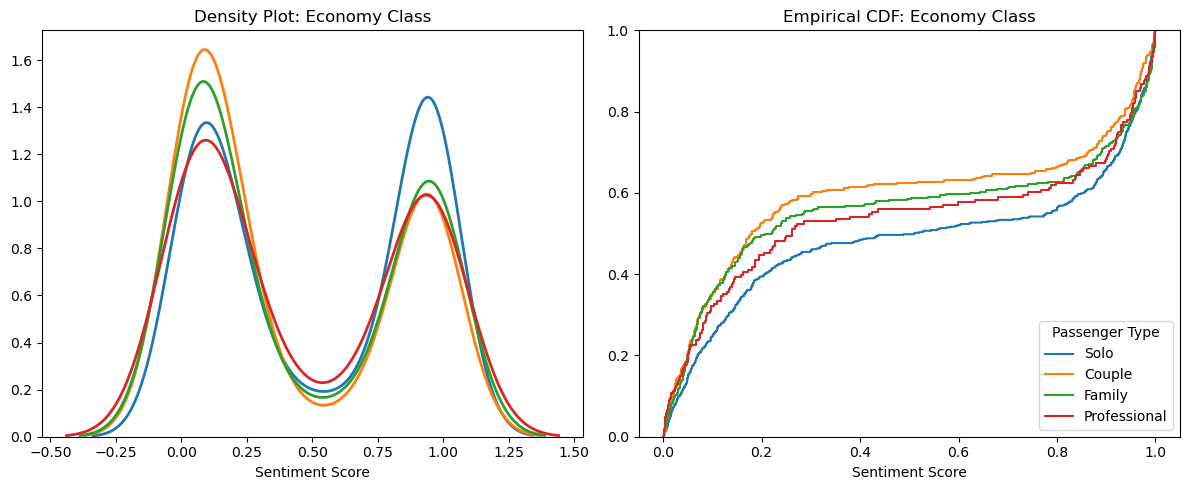

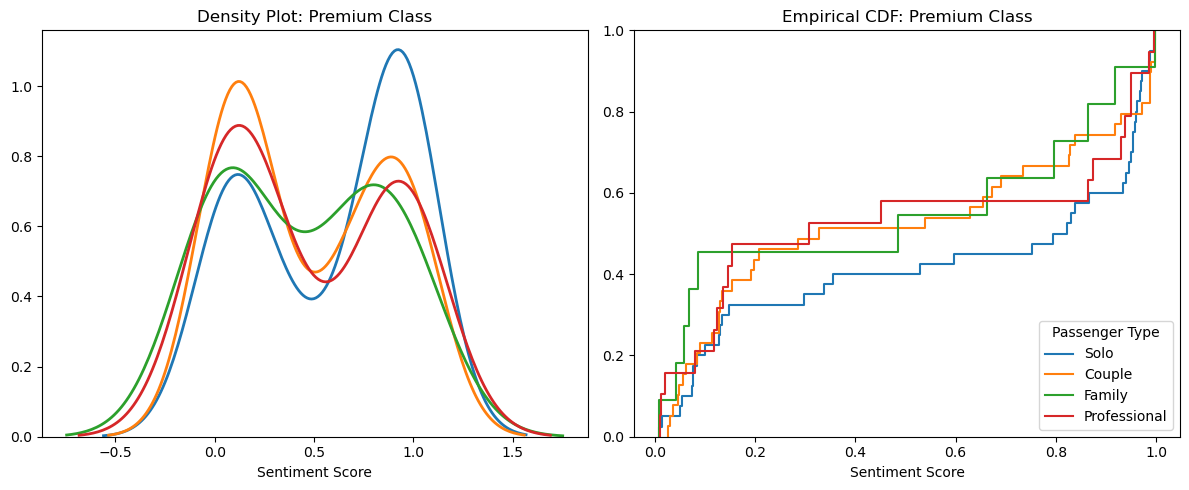

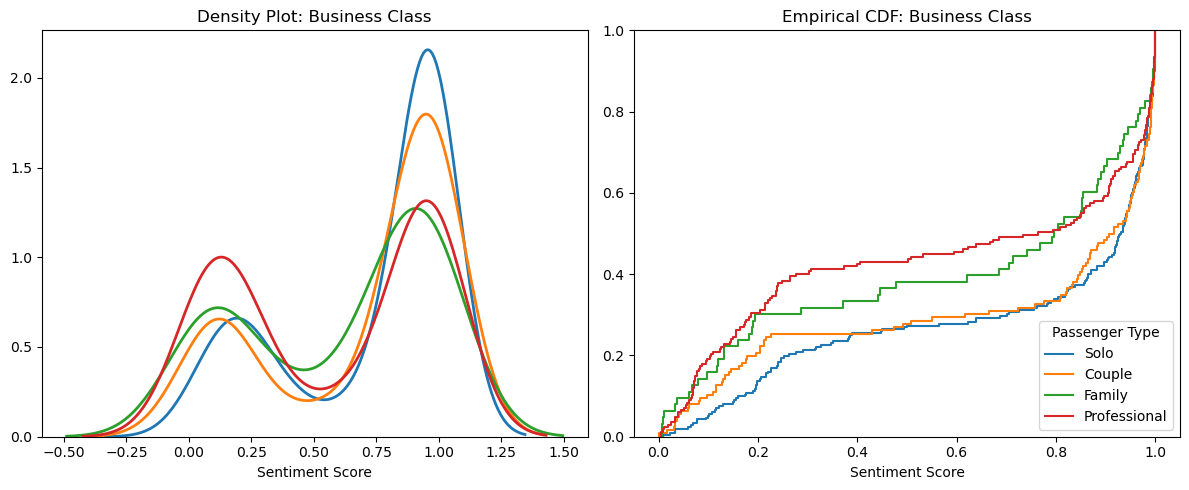

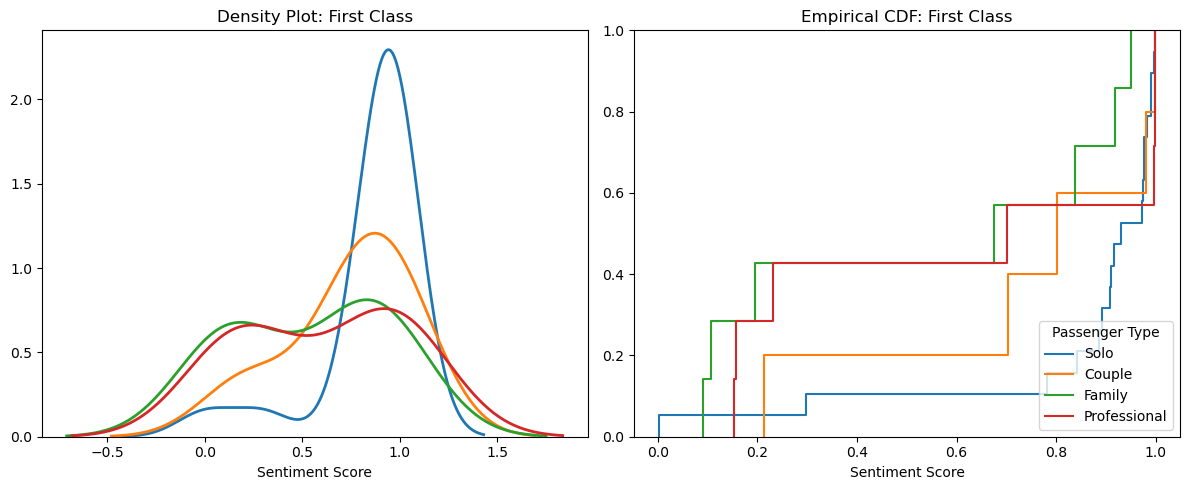

In [84]:
# Provide a KDE plot and an ECDF plot for the combination of Class and Type
display(Markdown("##### Combined Density And Accumulation Trends<br>"))

def plot_class_by_type_distributions(df, class_order, type_order, title="Passenger Satisfaction"):
    for cls in class_order:
        df_class = df[df['Class'] == cls]
        if df_class.empty:
            continue
            
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        type_palette = sns.color_palette("tab10", len(type_order))

        # KDE Plot
        for i, typ in enumerate(type_order):
            subset = df_class[df_class['Type'] == typ]
            if not subset.empty:
                sns.kdeplot(subset['Output'], label=typ, color=type_palette[i], linewidth=2, ax=axes[0])
        
        axes[0].set_title(f"Density Plot: {cls} Class")
        axes[0].set_xlabel("Sentiment Score")
        axes[0].set_ylabel('')

        # ECDF Plot
        for i, typ in enumerate(type_order):
            subset = df_class[df_class['Type'] == typ]
            if not subset.empty:
                sns.ecdfplot(subset['Output'], label=typ, color=type_palette[i], ax=axes[1])
        
        axes[1].set_title(f"Empirical CDF: {cls} Class")
        axes[1].set_xlabel("Sentiment Score")
        axes[1].set_ylabel('')
        axes[1].legend(title='Passenger Type', loc='lower right')

        plt.tight_layout()
        plt.show()
        print()

plot_class_by_type_distributions(df_pred, class_order, type_order)

#### Combined
Passenger sentiment varies significantly across both seating class and passenger type, with clear patterns of consistency, contrast, and variability emerging from the visual data.

**Solo** travelers consistently report the highest satisfaction across all seating classes. Their sentiment distributions are sharply skewed toward positive scores, especially in First and Premium Class, with minimal low-sentiment presence. Even in Economy and Business Class, Solo profiles remain more favorable than other groups.

**Couples** show a mixed sentiment profile that varies by class. In Economy and Premium Class, their density curves peak near the lowest sentiment scores, and their ECDFs rise steeply at the lower end, indicating early accumulation of dissatisfaction. In Business and First Class, however, the highest peaks shift toward the upper sentiment range, and the ECDFs rise more gradually, suggesting improved experiences in higher tiers. Overall, their sentiment distributions tend to show strong presence at both ends of the scale, with First Class being the exception.

**Families** exhibit broad and variable sentiment distributions. In Business Class, their density curves show distinct peaks near both low and high sentiment scores, indicating a wide spread of experiences. In First Class, the curve is relatively flat, with less pronounced peaks, suggesting more dispersed sentiment. ECDFs confirm early accumulation of low sentiment in most classes, pointing to inconsistent service outcomes and more complex travel dynamics.

**Professional** travelers display polarized sentiment profiles. In Premium and Business Class, their density curves show clear peaks near both low and high sentiment scores. ECDFs rise steeply at lower scores in Business Class, indicating a meaningful portion of dissatisfaction. In First Class, the distribution is flatter and more evenly spread, with no dominant peaks, this is the only tier where their sentiment appears relatively balanced.

Across seating classes, satisfaction generally increases with tier, but consistency depends heavily on passenger type. First Class delivers the most reliably positive experience for Solo travelers, while Premium Class shows the greatest variability across all groups. Economy Class reveals the sharpest contrast between Solo and Couple sentiment, highlighting how travel context amplifies or dampens perceived service quality.

In [86]:
# Create table of trends revealed in data
display(Markdown("##### Overall Trends<br>"))

patterns = [{'Seating Class': 'Economy', 
             'Most Satisfied Type': 'Solo', 
             'Most Variable Type': 'Family', 
             'Most Dissatisfied Type': 'Couple'},
            {'Seating Class': 'Premium', 
             'Most Satisfied Type': 'Solo', 
             'Most Variable Type': 'Couple', 
             'Most Dissatisfied Type': 'Couple'},
            {'Seating Class': 'Business', 
             'Most Satisfied Type': 'Solo', 
             'Most Variable Type': 'Professional', 
             'Most Dissatisfied Type': 'Couple'},
            {'Seating Class': 'First', 
             'Most Satisfied Type': 'Solo', 
             'Most Variable Type': 'Family', 
             'Most Dissatisfied Type': 'Family'}]

cross_table_curated = pd.DataFrame(patterns)
display(cross_table_curated)

##### Overall Trends<br>

,Seating Class,Most Satisfied Type,Most Variable Type,Most Dissatisfied Type
0,Economy,Solo,Family,Couple
1,Premium,Solo,Couple,Couple
2,Business,Solo,Professional,Couple
3,First,Solo,Family,Family


---
### Summary of Combined Analysis

Passenger satisfaction is influenced by both seating tier and travel context, with higher-tier seating generally associated with improved sentiment. However, the extent of this improvement is not uniform across passenger types—some benefit more than others, and consistency varies accordingly. Visual and statistical analyses reveal that while class elevation tends to enhance satisfaction, the magnitude and reliability of that enhancement are shaped by the traveler’s context, underscoring the need to consider both dimensions when evaluating experience quality.

#### Core Insights
- Satisfaction improves with tier, but passenger type modulates the benefit. Solo travelers gain the most from upgrades, while Families and Professionals often see less consistent improvement.
- Solo travelers thrive in premium environments. Their sentiment distributions are tightly clustered near the top, especially in Business and First Class, indicating reliably positive experiences.
- Couples and Families face persistent volatility. These groups show low average sentiment and high variability in Economy and Premium. Even in Business and First, their experiences remain more dispersed, suggesting that traveling with companions introduces emotional complexity and inconsistent service outcomes.
- Professional travelers are context-sensitive. Their sentiment improves in Business Class but remains flat and wide in First, reflecting a utilitarian experience shaped more by function than luxury.
- Economy Class amplifies dissatisfaction. For Couples and Families, it yields the lowest sentiment scores and widest emotional spread, reinforcing its role as the most volatile and least satisfying tier for group travel.
- First Class rewards individuals, not groups. While Solo and Couple travelers report exceptional satisfaction and consistency, Families and Professionals show dispersed sentiment, indicating that First Class may not meet the nuanced needs of group or professional travelers.


#### Strategic Implication
The data reveals a critical truth: Upgrades alone do not guarantee satisfaction. While higher-tier seating improves average sentiment, the emotional experience of passengers is shaped just as much by who they are and how they travel as by where they sit. To improve satisfaction and reduce variability, airlines must move beyond tier-based assumptions and adopt a context-aware service strategy. This means designing experiences that respond to the emotional, logistical, and relational dynamics of each passenger type.

**1. Segment by Passenger Type Before Optimizing by Class:**
Satisfaction is not uniformly distributed within seating tiers. Solo travelers thrive across all classes, while Couples and Families show persistent volatility. Service enhancements should be tailored to the needs of each group, not just the price point of the seat.

**2. Redesign Group Travel Experiences:**
Couples and Families consistently report lower and more variable sentiment, especially in Economy and Premium. This suggests that traveling with companions introduces friction, whether due to seating arrangements, service expectations, or emotional dynamics. Airlines should explore targeted interventions: coordinated seating, shared amenities, clearer communication, and staff training focused on group needs.

**3. Stabilize Premium Class Delivery:**
Premium Economy shows the greatest sentiment variability across all groups. This tier often promises elevated service but fails to deliver it consistently. Standardizing service touchpoints and clarifying expectations could reduce emotional spread and improve perceived value.

**4. Refine First Class for Non-Solo Travelers:**
While Solo travelers report exceptional satisfaction in First Class, Families and Professionals show more dispersed sentiment. This suggests that First Class may be optimized for individual luxury but not for group or business functionality. Enhancing flexibility, privacy, and personalization for these segments could unlock greater satisfaction.

**5. Use ECDFs to Monitor Sentiment Thresholds:**
Density plots reveal distribution shape, but ECDFs expose where dissatisfaction accumulates. Steep early rises signal systemic issues that may not be visible in averages. Airlines should incorporate ECDF diagnostics into their feedback systems to detect and address sentiment breakdowns early.

**6. Prioritize Consistency Over Elevation:**
Variability undermines perceived value more than low averages. Business travelers, for example, respond better to reliable service than to luxury. Reducing emotional spread, especially in mid-tier classes, should be a core operational goal.

Passenger satisfaction is not a linear function of price or tier. It’s a multidimensional outcome shaped by expectation, context, and consistency. Airlines that design with these factors in mind, tailoring service flows to the emotional realities of each passenger type, will not only improve sentiment but also build trust, loyalty, and long-term brand equity.

## <br>Amenities Analysis
* **Amenity Ratings:** Display amenity averages along with a graphical radar comparison of the average.
* **Descriptive Statistics:** Calculate and present descriptive statistics for the amenities.
* **Extremes Table:** Determine the amenity that is rated highest and lowest for each segment.

In [92]:
# Add Value and amenities columns to dataframe
columns_to_add = ['Food', 'Comfort', 'Entertainment', 'Ground', 'Staff', 'Value']
amenity_cols = columns_to_add[:-1] # Used for later operations

df_amenity = df_preproc[columns_to_add].copy()
df_pred = df_pred.set_index('Index').join(df_amenity, how='left').reset_index()

# Initialize scaler with fixed range 1–5 mapped to 0–1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array([1, 5]).reshape(-1, 1))

# Apply scaling and store in new columns
for col in columns_to_add:
    df_pred[f"{col}_scaled"] = scaler.transform(df_pred[[col]])

# Save the dataframe to file
df_pred.to_csv('airlines_reviews_amenities.csv', index=False, header=True)

##### Amenity Rating Averages<br>

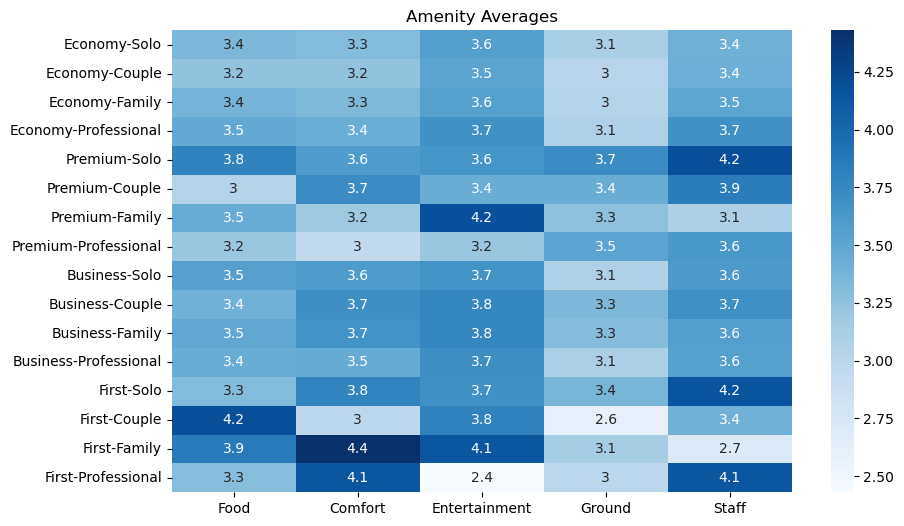

##### Radar Comparison<br>

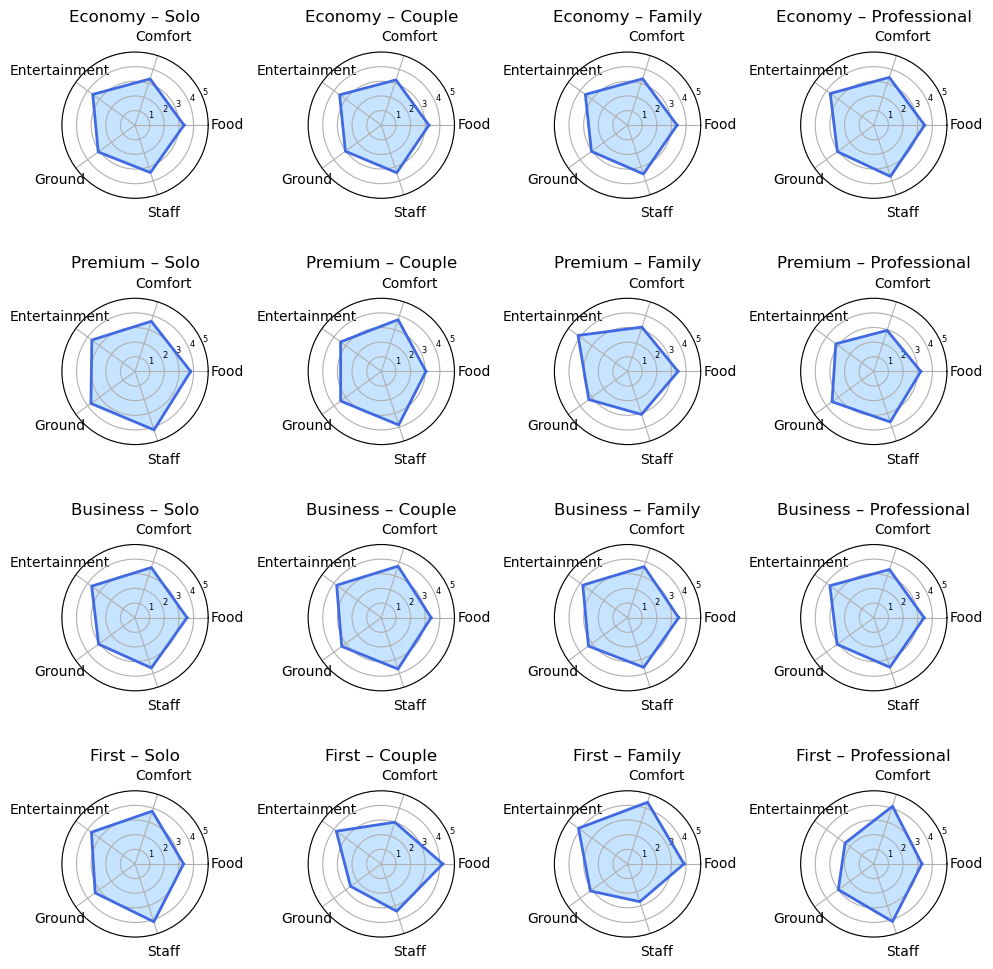

In [93]:
# Graph Amenity Satisfaction using heatmap and radar plot
display(Markdown("##### Amenity Rating Averages<br>"))
def plot_radar_grid(df, class_order=None, type_order=None):
    angles = np.linspace(0, 2 * np.pi, len(amenity_cols), endpoint=False).tolist()
    angles += angles[:1]
    fig, axes = plt.subplots(len(class_order), len(type_order), 
                             figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for i, cls in enumerate(class_order):
        for j, typ in enumerate(type_order):
            ax = axes[i, j]
            segment_df = df[(df['Class'] == cls) & (df['Type'] == typ)]
            mean_scores = segment_df[amenity_cols].mean().tolist()
            mean_scores += mean_scores[:1]

            ax.plot(angles, mean_scores, color='royalblue', linewidth=2)
            ax.fill(angles, mean_scores, color='dodgerblue', alpha=0.25)
            ax.set_title(f"{cls} – {typ}")
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(amenity_cols, fontsize=10)
            ax.set_yticks([1, 2, 3, 4, 5])
            ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=6)

    plt.tight_layout()
    plt.show()

segment_amenities = df_pred.groupby(['Class', 'Type'])[amenity_cols].mean().round(2)

# Reorder the DataFrame using the specified orders
segment_amenities_ordered = segment_amenities.reindex(class_order, level='Class')
segment_amenities_ordered = segment_amenities_ordered.reindex(type_order, level='Type')

# Plot the reordered DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(segment_amenities_ordered, annot=True, cmap='Blues')
plt.title("Amenity Averages")
plt.xlabel("")
plt.ylabel("")
plt.show()

display(Markdown("##### Radar Comparison<br>"))
plot_radar_grid(df_pred, class_order, type_order)

#### Amenities
**Solo** travelers are consistently satisfied across all classes, especially in Premium and First, making them ideal for premium targeting.

**Couples** show polarized sentiment, they rate onboard amenities like Food and Comfort highly but consistently report low satisfaction with Ground service, particularly in First Class.

**Families** respond strongly to Comfort and Entertainment, especially in First Class, but rate Staff lower in Premium and First, suggesting service delivery gaps for group dynamics.

**Professional** travelers are highly sensitive to Comfort and Entertainment quality. Their low scores in Premium and First Class indicate that luxury alone doesn’t meet business needs.

Ground service is the weakest amenity across all segments, with consistently lower scores and high variability, pointing to systemic issues in pre/post-flight logistics.

##### Amenity Statistics<br>

##### Seating Class:

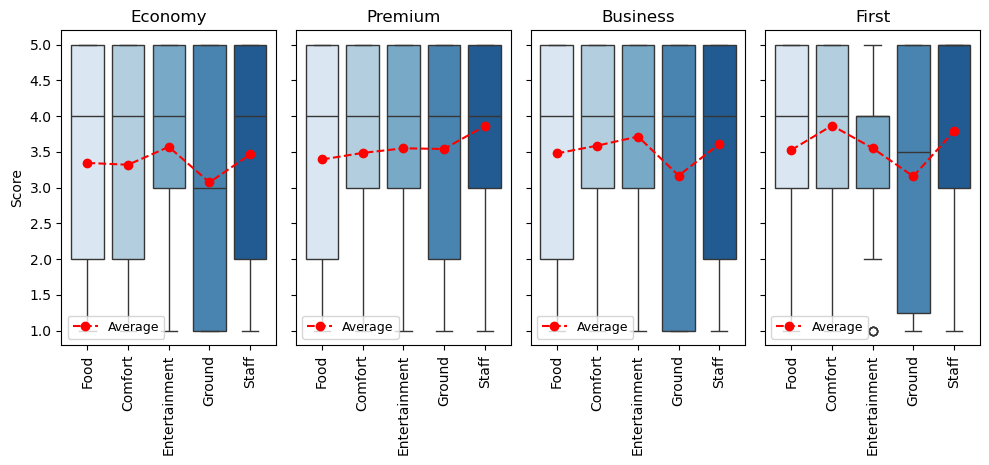


                        Mean Median    SD   MAD   IQR Variability Accuracy  Size
Class    Amenity                                                                
Economy  Food           3.35   4.00  1.49  1.32  3.00        5.81     0.89  1459
         Comfort        3.32   4.00  1.41  1.23  3.00        5.64     0.89  1459
         Entertainment  3.57   4.00  1.31  1.12  2.00        4.43     0.89  1459
         Ground         3.07   3.00  1.63  1.48  4.00        7.11     0.89  1459
         Staff          3.46   4.00  1.55  1.39  3.00        5.94     0.89  1459
Premium  Food           3.39   4.00  1.41  1.22  3.00        5.63     0.87   109
         Comfort        3.49   4.00  1.36  1.16  2.00        4.52     0.87   109
         Entertainment  3.55   4.00  1.28  1.04  2.00        4.32     0.87   109
         Ground         3.54   4.00  1.52  1.32  3.00        5.85     0.87   109
         Staff          3.86   4.00  1.36  1.12  2.00        4.48     0.87   109
Business Food           3.4

##### Passenger Type:

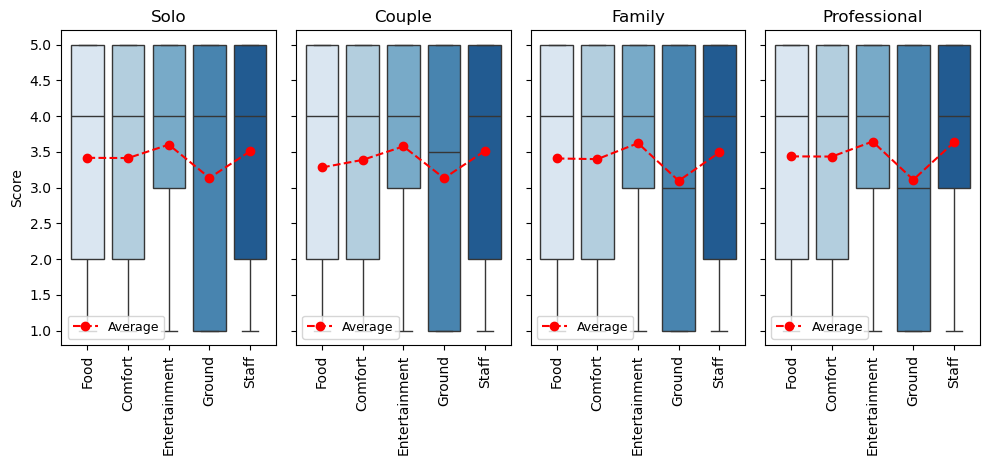


                            Mean Median    SD   MAD   IQR Variability Accuracy  Size
Type         Amenity                                                                
Solo         Food           3.42   4.00  1.46  1.28  3.00        5.74     0.88   867
             Comfort        3.41   4.00  1.37  1.18  3.00        5.55     0.88   867
             Entertainment  3.60   4.00  1.31  1.10  2.00        4.40     0.88   867
             Ground         3.14   4.00  1.64  1.49  4.00        7.12     0.88   867
             Staff          3.51   4.00  1.51  1.34  3.00        5.86     0.88   867
Couple       Food           3.28   4.00  1.48  1.31  3.00        5.80     0.89   530
             Comfort        3.39   4.00  1.44  1.26  3.00        5.69     0.89   530
             Entertainment  3.58   4.00  1.28  1.08  2.00        4.35     0.89   530
             Ground         3.13   3.50  1.60  1.44  4.00        7.04     0.89   530
             Staff          3.51   4.00  1.52  1.36  3.00       

In [95]:
def plot_amenity_ratings_by_segment(df, segment_col, segment_order, title):
    display(Markdown(f"##### {title}:"))
    fig, axes = plt.subplots(1, len(segment_order), figsize=(10, 5), sharey=True)

    for idx, segment in enumerate(segment_order):
        ax = axes[idx]
        subset = df[df[segment_col] == segment]
        melted = subset.melt(value_vars=amenity_cols, var_name='Amenity', value_name='Score')

        sns.boxplot(x='Amenity', y='Score', data=melted, ax=ax, palette='Blues')

        mean_scores = melted.groupby('Amenity')['Score'].mean().reindex(amenity_cols)
        ax.plot(range(len(amenity_cols)), mean_scores.values,
                color='red', linestyle='--', marker='o', label='Average')
        ax.set_title(f'{segment}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=90, labelsize=10)
        ax.legend(loc='lower left', fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def amenity_stats_by_group(df, group_col, group_order, amenity_cols):
    melted_value_name = 'AmenityScore'
    df_long = df.melt(
        id_vars=[group_col, 'Correct'],
        value_vars=amenity_cols,
        var_name='Amenity',
        value_name=melted_value_name)

    # Compute statistics
    stats = df_long.groupby([group_col, 'Amenity']).agg(
        Mean=(melted_value_name, 'mean'),
        Median=(melted_value_name, 'median'),
        SD=(melted_value_name, 'std'),
        MAD=(melted_value_name, lambda x: (x - x.mean()).abs().mean()),
        IQR=(melted_value_name, lambda x: x.quantile(0.75) - x.quantile(0.25)),
        Size=(melted_value_name, 'count'),
        Accuracy=('Correct', 'mean'))

    stats['Variability'] = stats['SD'] + stats['MAD'] + stats['IQR']

    # Reorder and format
    index_order = pd.MultiIndex.from_product([group_order, amenity_cols], names=[group_col, 'Amenity'])
    stats = stats.reindex(index_order)
    for col in ordered_cols[:-1]:
        stats[col] = stats[col].apply(lambda x: f"{x:.2f}")

    print(f"\n{stats[ordered_cols].to_string()}\n")

    return stats[ordered_cols]

display(Markdown("##### Amenity Statistics<br>"))
plot_amenity_ratings_by_segment(df_pred, 'Class', class_order, 'Seating Class')
class_amenity_stats = amenity_stats_by_group(df_pred, 'Class', class_order, amenity_cols)

plot_amenity_ratings_by_segment(df_pred, 'Type', type_order, 'Passenger Type')
type_amenity_stats = amenity_stats_by_group(df_pred, 'Type', type_order, amenity_cols)

#### Amenities Analysis
All classes, from Economy to First Class, show a consistent pattern of high satisfaction with Entertainment and persistent issues with Ground Service. The high variability in ground service across all tiers suggests it's a critical operational weakness that affects all passengers, regardless of their fare.

* Entertainment is the highest-rated amenity across all classes, with a consistently high mean score (ranging from 3.55 to 3.71) and notably low variability metrics, such as a Median of 4.00 and an IQR of 2.00 or less in most cases.
* First Class Entertainment stands out with exceptionally low variability (IQR: 1.00), suggesting a highly consistent and positive experience, which is not seen in other classes.
* While its variability remains high, the First Class Ground Service shows a slightly higher mean score and slightly lower variability metrics than other classes. This suggests a minor, but notable, improvement in this area for First Class passengers.

#### Insights by Passenger Type
Passenger type heavily influences sentiment.
* Solo travelers report the most consistent satisfaction across all amenities, suggesting a stable and predictable experience.
* Couples and families are less satisfied, with higher variability in their ratings, particularly concerning staff and ground service, pointing to service friction and operational gaps when traveling in groups.
* Professionals prioritize efficiency, rating entertainment highly. Their satisfaction with ground service is low (Mean: 3.11) and highly variable, reflecting their sensitivity to operational issues and the general weakness of this amenity across all passenger types.

##### Important Caveat
It is critical to interpret all findings for the First Class and Premium Class segments with caution. The small sample sizes for these groups—especially when broken down by amenity and passenger type—make any conclusions drawn from them more susceptible to statistical noise and less reliable for making broad generalizations.

In [97]:
# Identify highest and lowest rated amenities for each Class-Type combination
display(Markdown("##### Amenity Extremes<br>"))

highest = segment_amenities_ordered.idxmax(axis=1)
lowest = segment_amenities_ordered.idxmin(axis=1)
df_extremes = pd.DataFrame({'Highest Rated Amenity': highest, 'Lowest Rated Amenity': lowest})

display(df_extremes)

##### Amenity Extremes<br>

Highest Rated Amenity Lowest Rated Amenity
Class    Type                                                   
Economy  Solo                 Entertainment               Ground
         Couple               Entertainment               Ground
         Family               Entertainment               Ground
         Professional         Entertainment               Ground
Premium  Solo                         Staff              Comfort
         Couple                       Staff                 Food
         Family               Entertainment                Staff
         Professional                 Staff              Comfort
Business Solo                 Entertainment               Ground
         Couple               Entertainment               Ground
         Family               Entertainment               Ground
         Professional         Entertainment               Ground
First    Solo                         Staff                 Food
         Couple                        Food               Ground
         Family                     Comfort                Staff
         Professional               Comfort        Entertainment

---
### Summary of Amenity Analysis

This report analyzes passenger satisfaction across various seating classes and traveler types to identify key performance trends and strategic opportunities. Based on a detailed examination of sentiment scores for different amenities — including ground service, inflight entertainment, seating comfort, food and beverages, and inflight staff — the analysis highlights where the airlines are performing well and where they are falling short. The findings reveal that while core product offerings often meet expectations, inconsistencies in operational delivery, particularly for groups and business travelers, pose a significant risk to overall brand perception and loyalty.

#### Seating Class
**Economy Class** delivers a modest experience that’s generally consistent across passengers. While it doesn’t excel in any particular area, it offers a predictable baseline that meets essential expectations. Entertainment stands out as a relative strength, while logistical touchpoints like ground service tend to underwhelm.

**Premium Economy Class** offers glimpses of elevated service, particularly in interpersonal interactions, but struggles with consistency. Solo travelers tend to benefit most from its offerings, while group travelers encounter uneven delivery. The experience feels aspirational but not always reliably executed.

**Business Class** is the most balanced tier, delivering solid performance across amenities with minimal surprises. It caters well to both individual and group travelers, offering a dependable mix of comfort, entertainment, and service. Operational gaps remain, particularly in ground logistics, but overall satisfaction is steady.

**First Class** promises luxury and often delivers, especially in comfort and entertainment, but cracks appear when expectations rise. Solo travelers enjoy the most seamless experience, while families and couples encounter variability in service. The tier excels in core amenities but reveals inconsistencies in execution, particularly around coordination and support.

#### Passenger Type
**Solo** travelers consistently report the most positive and stable experiences. They benefit from streamlined service and tend to engage with amenities in ways that align well with how they’re delivered. Their satisfaction is reliable across tiers.

**Couples** show a more polarized response. They appreciate comfort and onboard experiences but often encounter friction in logistical areas. Their sentiment varies more sharply depending on the class, suggesting that coordination and service personalization are key to improving their journey.

**Families** respond strongly to amenities that support engagement and relaxation, such as entertainment and comfort. However, they frequently encounter challenges with staff responsiveness and coordination, especially in higher tiers. Their experience is emotionally rich but operationally fragile.

**Professional** travelers are highly sensitive to efficiency and consistency. They value amenities that support productivity and seamless movement, and their satisfaction hinges on how well those needs are met. When service delivery falters, especially in logistical areas, their sentiment drops sharply.


#### Strategic Recommendations
**1. Ground Service Requires Immediate Attention:**
Ground service consistently emerges as the weakest and most volatile amenity across all classes and passenger types. Its low satisfaction and high variability suggest systemic issues in check-in, boarding, and baggage handling. These touchpoints often shape first and last impressions, and when they falter, they erode the perceived value of even premium experiences. Addressing this should be a top operational priority, especially for high-value segments like Professionals and Couples in First Class.

**2. Entertainment Is a Reliable Strength:**
Entertainment consistently receives high ratings with low variability, making it one of the most dependable contributors to passenger satisfaction. This stability across tiers and types suggests that the current offering aligns well with passenger expectations. Rather than just maintaining it, there’s an opportunity to elevate it further, through personalization, content diversity, or integration with loyalty programs, to deepen engagement and differentiate the brand.

**3. Staff Delivery Needs Standardization for Group Travelers:**
Families and Couples show elevated variability in Staff ratings, especially in Premium and First Class. This points to inconsistent service delivery when passengers travel in groups. Crew training and service protocols should be refined to better support multi-passenger dynamics, whether that means coordinated seating, proactive assistance, or clearer communication. Consistency here can dramatically improve perceived hospitality.

**4. Comfort Is Tier-Sensitive and Drives Perceived Value:**
Comfort ratings improve steadily with class, peaking in First Class with minimal variability. This suggests that investments in seating, cabin layout, and ambient experience are paying off, but also that expectations rise sharply with price. Premium Class shows more variability, especially among Professionals, indicating that comfort enhancements in mid-tier cabins could yield outsized returns in satisfaction and loyalty.

**5. Solo Travelers Are Ideal for Loyalty and Upsell:**
Solo travelers consistently report high and stable satisfaction across all amenities. Their experience is less affected by coordination challenges and more responsive to personalized service. This makes them a prime segment for targeted marketing, loyalty incentives, and premium upsell strategies, especially in Business and First Class.

**6. Professionals Require Operational Precision:**
Professional travelers are highly sensitive to efficiency, consistency, and productivity support. Their lower satisfaction with Ground service and moderate variability in Comfort suggest that luxury alone doesn’t meet their needs. Enhancing business-friendly features, such as quiet zones, device support, and streamlined boarding, could significantly improve their experience and retention.